In [39]:
import pytesseract 
from PIL import Image, ImageDraw, ImageFont
import sys
import os

print(os.getcwd())
libtbb_name = os.path.expanduser("~/.local/lib/libtbb.so")

/Users/arunbhyashaswi/Drive/Code/Manga/LiveTranslatorScreen


In [40]:

import inspect

print(inspect.getfile(pytesseract))

/Users/arunbhyashaswi/.pyenv/versions/3.10.8/envs/man310/lib/python3.10/site-packages/pytesseract/__init__.py


In [41]:

print(pytesseract.pytesseract.tesseract_cmd)

/opt/homebrew/bin/tesseract


In [42]:
print(pytesseract.image_to_string(Image.open("/Users/arunbhyashaswi/Drive/Code/Manga/LiveTranslatorScreen/Sample/solo_leveling.jpg")))

BUT THE
ONLY DIFFERENCE
FROM THE FIRST
TIME IS THAT...

THIS
ISN'T A COMMAND,
BUT AN EARNEST
REQUEST.



In [43]:
from collections import deque 
import traceback
import threading
import math
import re
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from typing import Union, Callable, Any
from ultralytics import YOLO
import torch.nn as nn
import timm
import time
import largestinteriorrectangle as lir

from torchvision import transforms
from hyphen import Hyphenator
import random


In [44]:

IMAGE_SIZE = 224

In [45]:
# ! pip install --upgrade tbb

In [46]:

class PluginArgument:
    def __init__(self, id: str, name: str, description: str, default: str = "") -> None:
        self.id = id
        self.name = name
        self.type = PluginArgumentType.TEXT
        self.description = description
        self.default = default

    def get(self) -> dict[str, str]:
        return {
            "id": self.id,
            "name": self.name,
            "description": self.description,
            "default": self.default,
            "type": self.type,
        }
class OcrResult:
    def __init__(self, text: str = "", language: str = "en") -> None:
        self.text = text
        self.language = language

class BasePlugin:
    def __init__(self) -> None:
        pass

    @staticmethod
    def get_name() -> str:
        return "unknown"

    @staticmethod
    def get_arguments() -> list[PluginArgument]:
        return []

    @staticmethod
    def is_valid() -> bool:
        return True
    
    
     
# sys.platform
class Ocr(BasePlugin):
    """Always outputs \"Sample\" """

    def __init__(self) -> None:
        super().__init__()

    def __call__(self, batch: list[np.ndarray]) -> list[OcrResult]:#async 
        return self.do_ocr(batch)#await

    def do_ocr(self, batch: list[np.ndarray]):#async 
        return [OcrResult("Sample") for _ in batch]

    @staticmethod
    def get_name() -> str:
        return "Base Ocr"
    

class NoOcr(Ocr):
    """Does not perform any ocr on the image"""

    def __init__(self) -> None:
        super().__init__()

    def do_ocr(self, batch: list[np.ndarray]):#async 
        return [OcrResult("", "") for _ in batch]

    @staticmethod
    def get_name() -> str:
        return "No Ocr"

tesseract_paths = {
    'darwin': '/opt/homebrew/bin/tesseract',#'/usr/local/bin/tesseract',  # macOS
    'linux': '/usr/bin/tesseract',         # Linux
    'win32': r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Windows
}

tesseract_path = tesseract_paths.get(sys.platform)
if not tesseract_path:
    raise OSError(f"Unsupported platform: {sys.platform}")

print(f"Tesseract path for {sys.platform}: {tesseract_path}")
class TesseractOcr(Ocr):
    """Supports all the languages listed"""

    default_language = "jpn_vert"
    #if sys.platform
    tessaract_path = tesseract_paths.get(sys.platform)#os.path.abspath("C:\\Program Files\\Tesseract-OCR\\tesseract.exe")
    if not tesseract_path:
        raise OSError(f"Unsupported platform: {sys.platform}")

    print(f"Tesseract path for {sys.platform}: {tesseract_path}")

    def __init__(self, language=default_language) -> None:
        import pytesseract

        pytesseract.pytesseract.tesseract_cmd = TesseractOcr.tessaract_path
        super().__init__()
        self.tesseract = pytesseract
        self.language = language
    

    def do_ocr(self, batch: list[np.ndarray]):#async 

        return [OcrResult(
            text=self.tesseract.image_to_string(x, lang=self.language),
            language=simplify_lang_code(self.language),
        ) for x in batch]

    @staticmethod
    def get_name() -> str:
        return "Tesseract Ocr"

    @staticmethod
    def is_valid() -> bool:
        try:
            import pytesseract

            pytesseract.pytesseract.tesseract_cmd = TesseractOcr.tessaract_path
            pytesseract.get_tesseract_version()
            return True
        except:
            print(
                "Either pytesseract is having an error or you do not have it installed!."
            )
            return False

    @staticmethod
    def get_arguments() -> list[PluginArgument]:
        import pytesseract

        pytesseract.pytesseract.tesseract_cmd = TesseractOcr.tessaract_path
        languages = pytesseract.get_languages()
        languages.sort()
        if "jpn" in languages:
            languages.remove("jpn")
            languages.insert(0, "jpn")

        options = list(
            filter(
                lambda a: a.name is not None,
                [
                    PluginSelectArgumentOption(name=lang_code_to_name(lang), value=lang)
                    for lang in languages
                ],
            )
        )

        return [
            PluginSelectArgument(
                id="language",
                name="Language",
                description="The language to detect",
                options=options,
                default=languages[0],
            )
        ]
        # options = [PluginSelectArgumentOption(name=value,value=key) for key, value in EasyOcr.languages.items()]
        # options.sort(key= lambda a: "." if a.value == "ja" else a.name)
        # return [PluginSelectArgument(name="language",
        #                              description="The language to detect",
        #                              options=options)]
        
        
def get_ocr() -> list[Ocr]:
    return list(
        filter(lambda a: a.is_valid(), [NoOcr,
                                        TesseractOcr,
                                        EasyOcr])
    )


Tesseract path for darwin: /opt/homebrew/bin/tesseract
Tesseract path for darwin: /opt/homebrew/bin/tesseract


In [47]:
import easyocr


class EasyOcr(Ocr):
    """EasyOCR Plugin: Supports multiple languages"""

    languages = [
        "ja", "ko", "en", "ch_sim", "ch_tra", "fr", "de", "es", "ar", "ru", "hi" # Add more as needed
    ]

    def __init__(self, lang="ja") -> None:
        super().__init__()
        try:
            # Initialize EasyOCR reader
            self.easy = easyocr.Reader([lang], gpu=False)  # Set GPU to True if available
            self.language = lang
        except Exception as e:
            raise RuntimeError(f"Failed to initialize EasyOCR: {e}")

    def do_ocr(self, batch: list[np.ndarray]) -> list[OcrResult]:
        results = []
        for image in batch:
            try:
                # Perform OCR
                ocr_results = self.easy.readtext(image, detail=0, paragraph=True)
                text = " ".join(ocr_results) if ocr_results else ""
                results.append(OcrResult(text=text, language=self.language))
            except Exception as e:
                # Handle image processing errors
                results.append(OcrResult(text=f"Error: {str(e)}", language=self.language))
        return results

    @staticmethod
    def get_name() -> str:
        return "Easy OCR"

    @staticmethod
    def get_arguments() -> list[PluginArgument]:
        # Create language selection options
        options = [
            PluginSelectArgumentOption(name=lang_code_to_name(lang), value=lang)
            for lang in EasyOcr.languages
        ]

        return [
            PluginSelectArgument(
                id="lang",
                name="Language",
                description="The language to detect",
                options=options,
                default=options[0].value,
            )
        ]

In [48]:
class TranslatorResult:
    def __init__(self, text: str = "", lang_code: str = "en") -> None:
        self.lang_code = lang_code
        self.text = text
class Translator(BasePlugin):
    """Base Class for all Translator classes"""

    def __init__(self) -> None:
        super().__init__()

    def __call__(self, batch: list[OcrResult]) -> list[TranslatorResult]:#async 
        return self.translate(batch)#await

    def translate(self, batch: list[OcrResult]) -> list[TranslatorResult]:#async 
        return [TranslatorResult(x.text) for x in batch]

    @staticmethod
    def get_name() -> str:
        return "Base Translator"


In [49]:
class Drawable:
    def __init__(self,color: tuple[np.ndarray,np.ndarray,bool], translation: TranslatorResult,frame: np.ndarray) -> None:
        self.color = color
        self.translation = translation
        self.frame = frame
class Drawer(BasePlugin):
    def __init__(self) -> None:
        super().__init__()


    def draw(#async 
        self, batch: list[Drawable]
    ) -> list[tuple[np.ndarray,np.ndarray]]:
        return [x.frame for x in batch]

    def __call__(#async 
        self, batch: list[Drawable]
    ) -> list[tuple[np.ndarray,np.ndarray]]:
        return self.draw(batch=batch)#await 

class VerticalDrawer(Drawer):
    """Draws text vertically"""

    @staticmethod
    def is_valid() -> bool:
        return False

    @staticmethod
    def get_name() -> str:
        return "Vertical Drawer"
class HorizontalDrawer(Drawer):
    """Draws text horizontaly"""

    def __init__(
        self, font_file="fonts/animeace2_reg.ttf", max_font_size="30", line_spacing="2"
    ) -> None:
        super().__init__()
        self.font_file = font_file
        self.max_font_size = round(float(max_font_size))
        self.line_spacing = round(float(line_spacing))

    def draw(#async 
        self,batch: list[Drawable]
    ) -> list[tuple[np.ndarray,np.ndarray]]:
        #return await asyncio.gather(*[self.draw_one(x) for x in batch])#await 
        results = []
        for x in batch:
            result = self.draw_one(x)
            results.append(result)
        return results
                
    
    def draw_one(#async 
        self, item: Drawable
    ) -> tuple[np.ndarray,np.ndarray]:
        item_mask = np.zeros_like(item.frame)
        if len(item.translation.text.strip()) <= 0:
            return (item.frame,item_mask)

        frame_h, frame_w, _ = item.frame.shape
        hyphenator = Hyphenator("en_US")

        font_size, chars_per_line, line_height, iters = get_best_font_size(
            item.translation.text,
            (frame_w, frame_h),
            font_file=self.font_file,
            space_between_lines=self.line_spacing,
            start_size=self.max_font_size,
            step=1,
            hyphenator=hyphenator,
        )

        if not font_size:
            return (item.frame,item_mask)

        font = ImageFont.truetype(self.font_file, font_size)

        font
        draw_x = 0
        draw_y = 0

        wrapped = wrap_text(item.translation.text, chars_per_line, hyphenator=hyphenator)

        frame_as_pil = cv2_to_pil(item.frame)
        
        mask_as_pil = cv2_to_pil(item_mask)

        image_draw = ImageDraw.Draw(frame_as_pil)

        mask_draw = ImageDraw.Draw(mask_as_pil)

        color_fg,color_bg,should_do_bg = item.color
        
        stroke_width = 2 if should_do_bg else 0
        for line_no in range(len(wrapped)):
            line = wrapped[line_no]
            x, y, w, h = font.getbbox(line)

            image_draw.text(
                (
                    draw_x + abs(((frame_w - w) / 2)),
                    draw_y
                    + self.line_spacing
                    + (
                        (
                            frame_h
                            - (
                                (len(wrapped) * line_height)
                                + (len(wrapped) * self.line_spacing)
                            )
                        )
                        / 2
                    )
                    + (line_no * line_height)
                    + (self.line_spacing * line_no),
                ),
                str(line),
                fill=(*color_fg,255),
                font=font,
                stroke_width=stroke_width,
                stroke_fill=(*color_bg,255) if stroke_width > 0 else None
            )

            mask_draw.text(
                (
                    draw_x + abs(((frame_w - w) / 2)),
                    draw_y
                    + self.line_spacing
                    + (
                        (
                            frame_h
                            - (
                                (len(wrapped) * line_height)
                                + (len(wrapped) * self.line_spacing)
                            )
                        )
                        / 2
                    )
                    + (line_no * line_height)
                    + (self.line_spacing * line_no),
                ),
                str(line),
                fill=(255, 255, 255, 255),
                font=font,
                stroke_width=stroke_width,
                stroke_fill=(255, 255, 255) if stroke_width > 0 else None
            )

        mask_cv2 = cv2.cvtColor(pil_to_cv2(mask_as_pil),cv2.COLOR_BGR2GRAY)

        _, binary_mask = cv2.threshold(mask_cv2, 1, 255, cv2.THRESH_BINARY)

        return (pil_to_cv2(frame_as_pil),binary_mask)
        

    @staticmethod
    def get_arguments() -> list[PluginArgument]:
        fonts_available = get_fonts()
        return [
            PluginSelectArgument(
                id="font_file",
                name="Font",
                description="The font to draw with",
                options=list(
                    map(
                        lambda a: PluginSelectArgumentOption(name=a[0], value=a[1]),
                        fonts_available,
                    )
                ),
                default=fonts_available[0][1],
            ),
            PluginArgument(
                id="max_font_size",
                name="Max Font Size",
                description="The max font size for the sizing algorithm",
                default="30",
            ),
            PluginArgument(
                id="line_spacing",
                name="Line Spacing",
                description="Space between lines",
                default="2",
            ),
        ]

    @staticmethod
    def get_name() -> str:
        return "Horizontal Drawer"
    
def get_drawers() -> list[Drawer]:
    return list(filter(lambda a: a.is_valid(), [HorizontalDrawer, VerticalDrawer]))

In [50]:
def ensure_gray(img: np.ndarray):
    if len(img.shape) > 2:
        return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    return img.copy()

def has_white(image: np.ndarray):
    # Set RGB values for white
    white_lower = np.array([200, 200, 200], dtype=np.uint8)
    white_upper = np.array([255, 255, 255], dtype=np.uint8)

    # Find white pixels within the specified range
    white_pixels = cv2.inRange(image, white_lower, white_upper)

    # Check if any white pixels were found
    return cv2.countNonZero(white_pixels) > 0

def apply_mask(foreground: np.ndarray, background: np.ndarray, mask: np.ndarray, inv=False):
    mask = ensure_gray(mask)
    a_loc, b_loc = foreground.copy(), background.copy()
    mask_inv = cv2.bitwise_not(mask)

    if inv:
        temp = mask
        mask = mask_inv
        mask_inv = temp

    a_loc = cv2.bitwise_and(a_loc, a_loc, mask=mask)
    b_loc = cv2.bitwise_and(b_loc, b_loc, mask=mask_inv)
    return cv2.add(a_loc, b_loc)

def get_masked_bounds(mask: np.ndarray):
    gray = ensure_gray(mask)

    # Threshold the image
    ret, thresh = cv2.threshold(gray, 200, 255, 0)

    # Find contours
    contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )
    all_contours = []
    for c in contours:
        all_contours.extend(c)
    # display_image(mask,"Test")
    x, y, w, h = cv2.boundingRect(np.array(all_contours))

    return x, y, x + w, y + h

def mask_text_for_in_painting(frame: np.ndarray, mask: np.ndarray):
    image = frame.copy()

    hist = get_histogram_for_region(frame, np.full_like(frame, 255, dtype=frame.dtype))

    # Find the bin with the highest frequency
    max_bin = np.unravel_index(hist.argmax(), hist.shape)

    # Retrieve the corresponding color value
    is_white = (
        ((max_bin[2] + max_bin[1] + max_bin[0]) / 3) / 255
    ) > 0.5  # checks if the dominant color is bright or dark with a 0.5 threshold

    if not is_white:
        image = cv2.bitwise_not(image)

    # Convert the image to grayscale
    gray = cv2.GaussianBlur(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), (7, 7), 0)

    # Apply adaptive thresholding to the grayscale image
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 4
    )  # 15, 5)

    # Perform morphological operations to improve the text extraction
    kernel_size = 1
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    opening = cv2.bitwise_and(opening, opening, mask=ensure_gray(mask))

    # Find contours of the characters
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank mask image
    new_mask = np.zeros_like(image)

    # Draw contours on the mask
    for contour in contours:
        # Filter out small contours and contours with a large aspect ratio
        (x, y, w, h) = cv2.boundingRect(contour)
        ratio = (w * h) / (len(image) * len(image[0]))
        # print(ratio)
        if ratio < 1:
            # print(ratio)

            cv2.drawContours(
                new_mask, [contour], -1, (255, 255, 255), thickness=cv2.FILLED
            )

            # debug_image(mask,"Segments")

    return new_mask
def get_histogram_for_region(frame: np.ndarray, region_mask=None):
    masked_frame = cv2.bitwise_and(
        frame,
        frame,
        mask=ensure_gray(
            region_mask if region_mask is not None else np.full_like(frame, 255)
        ),
    )
    return cv2.calcHist(
        [masked_frame], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256]
    )

def get_masked_bounds(mask: np.ndarray):
    gray = ensure_gray(mask)

    # Threshold the image
    ret, thresh = cv2.threshold(gray, 200, 255, 0)

    # Find contours
    contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )
    all_contours = []
    for c in contours:
        all_contours.extend(c)
    # display_image(mask,"Test")
    x, y, w, h = cv2.boundingRect(np.array(all_contours))

    return x, y, x + w, y + h
def mask_text_and_make_bubble_mask(
    frame: np.ndarray, frame_text_mask: np.ndarray, frame_cleaned: np.ndarray
):
    # debug_image(frame_cleaned)
    x1, y1, x2, y2 = get_masked_bounds(frame_text_mask)

    frame_section = frame.copy()[y1:y2, x1:x2]

    mask_section = frame_text_mask.copy()[y1:y2, x1:x2]

    text = apply_mask(
        frame_section,
        np.full(frame_section.shape, 255, dtype=frame_section.dtype),
        mask_section,
    )

    return text, make_bubble_mask(frame_cleaned)


def make_bubble_mask(frame: np.ndarray):
    image = frame.copy()
    # Apply a Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Use the Canny edge detection algorithm
    edges = cv2.Canny(blurred, 50, 150)

    # # Apply morphological closing to close gaps in the circle
    # kernel = np.ones((9, 9), np.uint8)
    # closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # _, binary_image = cv2.threshold(inverted, 200, 255, cv2.THRESH_BINARY)

    # Find contours in the image
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # Create a black image with the same size as the original

    stage_1 = cv2.drawContours(
        np.zeros_like(image), contours, -1, (255, 255, 255), thickness=2
    )

    stage_1 = cv2.bitwise_not(stage_1)

    stage_1 = cv2.cvtColor(stage_1, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(stage_1, 200, 255, cv2.THRESH_BINARY)

    # Find connected components in the binary image
    num_labels, labels = cv2.connectedComponents(binary_image)

    largest_island_label = np.argmax(np.bincount(labels.flat)[1:]) + 1

    mask = np.zeros_like(image)

    mask[labels == largest_island_label] = 255

    # mask = cv2.bitwise_not(mask)

    _, mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to remove black spots
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return adjust_contrast_brightness(mask, 100)


In [51]:

class TranslatorGlobals:
    COLOR_BLACK = np.array((0, 0, 0))
    COLOR_WHITE = np.array((255, 255, 255))
def get_torch_device() -> torch.device:
    return torch.device('cuda') if torch.cuda.is_available() else (torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu'))

def simplify_lang_code(code: str) -> Union[str, None]:
    try:
        lang = pycountry.languages.lookup(code)

        return getattr(lang, "alpha_2", getattr(lang, "alpha_3", None))
    except:
        return code


def get_languages() -> list[tuple[str, str]]:
    return list(
        filter(
            lambda a: a[1] is not None,
            list(
                map(
                    lambda a: (
                        a.name,
                        getattr(a, "alpha_2", getattr(a, "alpha_3", None)),
                    ),
                    list(pycountry.languages),
                )
            ),
        )
    )


def lang_code_to_name(code: str) -> Union[str, None]:
    try:
        return pycountry.languages.lookup(code).name
    except:
        return None


def adjust_contrast_brightness(
    img: np.ndarray, contrast: float = 1.0, brightness: int = 0
):
    """
    Adjusts contrast and brightness of an uint8 image.
    contrast:   (0.0,  inf) with 1.0 leaving the contrast as is
    brightness: [-255, 255] with 0 leaving the brightness as is
    """
    brightness += int(round(255 * (1 - contrast) / 2))
    return cv2.addWeighted(img, contrast, img, 0, brightness)


def measure_runtime(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        print(f"{func.__name__} Took {((time.time() - start) * 1000):.6f} MS")
        return result

    return wrapper


def has_white(image: np.ndarray):
    # Set RGB values for white
    white_lower = np.array([200, 200, 200], dtype=np.uint8)
    white_upper = np.array([255, 255, 255], dtype=np.uint8)

    # Find white pixels within the specified range
    white_pixels = cv2.inRange(image, white_lower, white_upper)

    # Check if any white pixels were found
    return cv2.countNonZero(white_pixels) > 0


display_image_lock = threading.Lock()


def display_image(img: np.ndarray, name: str = "debug"):
    global display_image_lock

    with display_image_lock:
        # Convert the CV2 image array to a format compatible with PySimpleGUI
        image_bytes = cv2.imencode(".png", img)[1].tobytes()

        # Create the GUI layout
        layout = [
            [sg.Text(text=name)],
            [sg.Image(data=image_bytes)],
            [sg.Button("Save"), sg.Button("Close")],
        ]

        # Create the window
        window = sg.Window(name, layout)

        # Event loop to handle events
        while True:
            event, values = window.read()
            if event == sg.WINDOW_CLOSED or event == "Close":
                break

            if event == "Save":
                cv2.imwrite(name + ".png", img)

        # Close the window
        window.close()


def ensure_gray(img: np.ndarray):
    if len(img.shape) > 2:
        return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    return img.copy()


def apply_mask(foreground: np.ndarray, background: np.ndarray, mask: np.ndarray, inv=False):
    mask = ensure_gray(mask)
    a_loc, b_loc = foreground.copy(), background.copy()
    mask_inv = cv2.bitwise_not(mask)

    if inv:
        temp = mask
        mask = mask_inv
        mask_inv = temp

    a_loc = cv2.bitwise_and(a_loc, a_loc, mask=mask)
    b_loc = cv2.bitwise_and(b_loc, b_loc, mask=mask_inv)
    return cv2.add(a_loc, b_loc)

In [52]:
def make_bubble_mask(frame: np.ndarray):
    image = frame.copy()
    # Apply a Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Use the Canny edge detection algorithm
    edges = cv2.Canny(blurred, 50, 150)

    # # Apply morphological closing to close gaps in the circle
    # kernel = np.ones((9, 9), np.uint8)
    # closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # _, binary_image = cv2.threshold(inverted, 200, 255, cv2.THRESH_BINARY)

    # Find contours in the image
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # Create a black image with the same size as the original

    stage_1 = cv2.drawContours(
        np.zeros_like(image), contours, -1, (255, 255, 255), thickness=2
    )

    stage_1 = cv2.bitwise_not(stage_1)

    stage_1 = cv2.cvtColor(stage_1, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(stage_1, 200, 255, cv2.THRESH_BINARY)

    # Find connected components in the binary image
    num_labels, labels = cv2.connectedComponents(binary_image)

    largest_island_label = np.argmax(np.bincount(labels.flat)[1:]) + 1

    mask = np.zeros_like(image)

    mask[labels == largest_island_label] = 255

    # mask = cv2.bitwise_not(mask)

    _, mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to remove black spots
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return adjust_contrast_brightness(mask, 100)


def get_masked_bounds(mask: np.ndarray):
    gray = ensure_gray(mask)

    # Threshold the image
    ret, thresh = cv2.threshold(gray, 200, 255, 0)

    # Find contours
    contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )
    all_contours = []
    for c in contours:
        all_contours.extend(c)
    # display_image(mask,"Test")
    x, y, w, h = cv2.boundingRect(np.array(all_contours))

    return x, y, x + w, y + h


def get_histogram_for_region(frame: np.ndarray, region_mask=None):
    masked_frame = cv2.bitwise_and(
        frame,
        frame,
        mask=ensure_gray(
            region_mask if region_mask is not None else np.full_like(frame, 255)
        ),
    )
    return cv2.calcHist(
        [masked_frame], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256]
    )


def mask_text_and_make_bubble_mask(
    frame: np.ndarray, frame_text_mask: np.ndarray, frame_cleaned: np.ndarray
):
    # debug_image(frame_cleaned)
    x1, y1, x2, y2 = get_masked_bounds(frame_text_mask)

    frame_section = frame.copy()[y1:y2, x1:x2]

    mask_section = frame_text_mask.copy()[y1:y2, x1:x2]

    text = apply_mask(
        frame_section,
        np.full(frame_section.shape, 255, dtype=frame_section.dtype),
        mask_section,
    )

    return text, make_bubble_mask(frame_cleaned)


def cv2_to_pil(img: np.ndarray) -> Image:
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


def pil_to_cv2(img: Image) -> np.ndarray:
    arr = np.array(img)

    if len(arr.shape) > 2 and arr.shape[2] == 4:
        return cv2.cvtColor(np.array(img), cv2.COLOR_RGBA2BGR)

    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)


def get_bounds_for_text(frame_mask: np.ndarray):
    gray = ensure_gray(frame_mask)
    # Threshold the image
    ret, thresh = cv2.threshold(gray, 200, 255, 0)

    # Find contours
    contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )

    largest_contour = max(contours, key=cv2.contourArea)
    polygon = np.array([largest_contour[:, 0, :]])

    rect = lir.lir(polygon)

    return lir.pt1(rect), lir.pt2(rect)


In [53]:



def fix_order_after_intersection_fix(
    a1: int, a2: int, b1: int, b2: int, was_sorted: bool, was_intersecting: bool = False
):
    if was_sorted:
        return b1, b2, a1, a2, was_intersecting

    return a1, a2, b1, b2, was_intersecting


def fix_intersection(
    a1: int, a2: int, b1: int, b2: int, sorted: bool = False, was_sorted: bool = False
):
    if not sorted:
        if a1[0] < b1[0]:
            return fix_intersection(a1, a2, b1, b2, True)
        else:
            return fix_intersection(b1, b2, a1, a2, True, True)

    a_width = a2[0] - a1[0]
    a_height = a2[1] - a1[1]
    b_width = b2[0] - b1[0]
    b_height = b2[1] - b1[1]
    # a is above b
    if a1[1] < b1[1]:
        is_intersecting = a1[0] < b1[0] < a2[0] and a1[1] < b1[1] < a2[1]
        if not is_intersecting:
            return fix_order_after_intersection_fix(a1, a2, b1, b2, was_sorted)

        midpoint_x = max(abs(int(((a2[0] - b1[0]) / 2))) + 1, 3)

        midpoint_y = abs(int(((a2[1] - b1[1]) / 2))) + 1
        return fix_order_after_intersection_fix(a1, a2, b1, b2, was_sorted, True)
    else:
        is_intersecting = a1[0] < b1[0] < a2[0] and b1[1] < a1[1] < b2[1]
        if not is_intersecting:
            return fix_order_after_intersection_fix(a1, a2, b1, b2, was_sorted)

        midpoint_x = max(abs(int(((a2[0] - b1[0]) / 2))) + 1, 3)

        midpoint_y = abs(int(((b2[1] - a1[0]) / 2))) + 1

        return fix_order_after_intersection_fix(a1, a2, b1, b2, was_sorted, True)


def simplify_points(points: np.ndarray):
    hull = cv2.convexHull(points)

    simplified_points = np.array([np.array(x) for x in hull.squeeze().tolist()])

    return simplified_points


def mask_text_for_in_painting(frame: np.ndarray, mask: np.ndarray):
    image = frame.copy()

    hist = get_histogram_for_region(frame, np.full_like(frame, 255, dtype=frame.dtype))

    max_bin = np.unravel_index(hist.argmax(), hist.shape)

    is_white = (
        ((max_bin[2] + max_bin[1] + max_bin[0]) / 3) / 255
    ) > 0.5  # checks if the dominant color is bright or dark with a 0.5 threshold

    if not is_white:
        image = cv2.bitwise_not(image)

    # Convert the image to grayscale
    gray = cv2.GaussianBlur(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), (7, 7), 0)

    # Apply adaptive thresholding to the grayscale image
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 4
    )  # 15, 5)

    # Perform morphological operations to improve the text extraction
    kernel_size = 1
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    opening = cv2.bitwise_and(opening, opening, mask=ensure_gray(mask))

    # Find contours of the characters
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank mask image
    new_mask = np.zeros_like(image)

    # Draw contours on the mask
    for contour in contours:
        # Filter out small contours and contours with a large aspect ratio
        (x, y, w, h) = cv2.boundingRect(contour)
        ratio = (w * h) / (len(image) * len(image[0]))
        # print(ratio)
        if ratio < 1:
            # print(ratio)

            cv2.drawContours(
                new_mask, [contour], -1, (255, 255, 255), thickness=cv2.FILLED
            )

            # debug_image(mask,"Segments")

    return new_mask


In [54]:
def in_paint_optimized(
    frame: np.ndarray,
    mask: np.ndarray,
    filtered: list[tuple[tuple[int, int, int, int], str, float]] = [],
    max_height: int = 256,
    max_width: int = 256,
    mask_dilation_kernel_size: int = 9,
    inpaint_fun: Callable[[np.ndarray, np.ndarray], np.ndarray] = lambda a, b: a,
) -> tuple[np.ndarray, np.ndarray]:
    h, w, c = frame.shape
    max_height = int(math.floor(max_height / 8) * 8)
    max_width = int(math.floor(max_width / 8) * 8)

    # only inpaint sections with masks and isolate said masks
    final = frame.copy()
    text_mask = np.zeros_like(mask)

    half_height = int(max_height / 2)
    half_width = int(max_width / 2)

    for bbox, cls, conf in filtered:
        try:
            bx1, by1, bx2, by2 = bbox
            bx1, by1, bx2, by2 = round(bx1), round(by1), round(bx2), round(by2)

            half_bx = round((bx2 - bx1) / 2)
            half_by = round((by2 - by1) / 2)
            midpoint_x, midpoint_y = round(bx1 + half_bx), round(by1 + half_by)

            x1, y1 = max(0, midpoint_x - half_width), max(0, midpoint_y - half_height)

            x2, y2 = min(w, midpoint_x + half_width), min(h, midpoint_y + half_height)

            if y2 < by2:
                y2 = by2

            if y1 > by1:
                y1 = by1

            if x2 < bx2:
                x2 = bx2

            if x1 > bx1:
                x1 = bx1

            overflow_x = (x2 - x1) % 8
            x1_adjust = 0
            if overflow_x != 0:
                if x2 > x1:
                    x2 -= overflow_x
                else:
                    x1 += overflow_x
                    x1_adjust = overflow_x

            overflow_y = (y2 - y1) % 8

            y1_adjust = 0
            if overflow_y != 0:
                if y2 > y1:
                    y2 -= overflow_y
                else:
                    y1 += overflow_y
                    y1_adjust = overflow_y

            bx1 = bx1 - (x1 + x1_adjust)
            bx2 = bx2 - (x1 + x1_adjust)
            by1 = by1 - (y1 + y1_adjust)
            by2 = by2 - (y1 + y1_adjust)

            region_mask = mask[y1:y2, x1:x2].copy()

            focus_mask = cv2.rectangle(
                np.zeros_like(region_mask),
                (bx1, by1),
                (bx2, by2),
                (255, 255, 255),
                -1,
            )

            region_mask = apply_mask(
                region_mask, np.zeros_like(region_mask), focus_mask
            )

            if has_white(region_mask):
                (
                    target_region_x1,
                    target_region_y1,
                    target_region_x2,
                    target_region_y2,
                ) = get_masked_bounds(region_mask)

                section_to_in_paint = final[y1:y2, x1:x2]

                section_to_refine = section_to_in_paint[
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ]
                section_to_refine_mask = region_mask[
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ]

                # Generate a mask of the actual characters/text
                refined_mask = np.zeros_like(region_mask)
                refined_mask[
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ] = mask_text_for_in_painting(section_to_refine, section_to_refine_mask)

                # The text mask is used for other stuff so we set it here before we dilate for inpainting
                text_mask[y1:y2, x1:x2][
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ] = refined_mask[
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ].copy()

                # Dilate the text mask for inpainting
                kernel = np.ones(
                    (mask_dilation_kernel_size, mask_dilation_kernel_size), np.uint8
                )
                refined_mask = cv2.dilate(refined_mask, kernel, iterations=1)

                # Inpaint using the dilated text mask
                final[y1:y2, x1:x2][
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ] = inpaint_fun(final[y1:y2, x1:x2], refined_mask)[
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ]
        except:
            traceback.print_exc()
            continue

    return final, text_mask


def pixels_to_pt(pixels: int):
    return pixels * 12 / 16


def pt_to_pixels(pt: int):
    return pt * (16 / 12)


def try_merge_hyphenated(text: list[str], max_chars: int):
    final = []
    total = deque(text)
    current = total.popleft().strip()

    while len(total) > 0 or current != "":
        if (
            len(total) > 0
            and current.endswith("-")
            and len(current[:-1] + total[0]) <= max_chars
        ):
            current = current[:-1] + total.popleft().strip()

        else:
            final.append(current)
            current = total.popleft() if len(total) > 0 else ""

    return final


In [55]:
def wrap_text(text: str, max_chars: int, hyphenator: Union[Hyphenator, None]):
    total = deque(list(filter(lambda a: len(a.strip()) > 0, text.split(" "))))
    current_word = total.popleft()
    lines = []
    current_line = ""
    while len(total) > 0 or len(current_word) > 0:
        sep = " " if len(current_line) > 0 else ""
        new_current = current_line + sep + current_word
        if len(new_current) > max_chars:
            space_left = max_chars - len(current_line + sep)

            try:
                if "-" in current_word:
                    idx = current_word.index("-")
                    total.appendleft(current_word[idx + 1 :])
                    current_word = current_word[:idx]
                    continue
                elif hyphenator is not None:
                    pairs = hyphenator.pairs(current_word)
                else:
                    pairs = []
            except:
                print("EXCEPTION WHEN HYPHENATING:", current_word)
                pairs = []
            if len(pairs) == 0:
                if current_line == "" and len(current_word) > max_chars:
                    return None
                lines.append(current_line)
                current_line = ""
                continue

            pair = min(pairs, key=lambda a: len(current_line + sep + a[0] + "-"))
            if len(current_line + sep + pair[0] + "-") > space_left:
                lines.append(current_line)
                if len(pair[0] + "-") <= max_chars:
                    lines.append(pair[0] + "-")
                    current_line = ""
                    current_word = pair[1]
                    continue
                else:
                    return None

            lines.append(current_line + sep + pair[0] + "-")
            current_line = ""
            current_word = pair[1]
        elif len(total) == 0:
            lines.append(current_line + sep + current_word)
            current_word = ""
        else:
            current_line = new_current
            current_word = total.popleft() if len(total) else ""

    return try_merge_hyphenated(lines, max_chars)


def get_fonts() -> list[tuple[str, str]]:
    fonts = []
    for file in filter(lambda a: a.endswith(".ttf"), os.listdir("./fonts")):
        fonts.append((file[0:-4], os.path.abspath(os.path.join("./fonts", file))))

    return fonts


def get_model_path(model=""):
    return os.path.join(os.path.abspath("./models"), model)


def get_average_font_size(font: ImageFont, text="some text here"):
    x, y, w, h = font.getbbox(text)
    widths = list(map(lambda a: font.getbbox(a)[2], list(text)))
    widths.sort(reverse=True)
    return widths[1] if len(widths) > 1 else widths[0], h


In [56]:


def get_best_font_size(
    text: str,
    wh: tuple[int, int],
    font_file: str,
    space_between_lines: int = 1,
    start_size: int = 18,
    step: int = 1,
    min_chars_per_line: int = 6,
    initial_iterations: int = 0,
    hyphenator: Union[Hyphenator, None] = None,
) -> Union[tuple[None, None, None, int], tuple[int, int, int, int]]:
    current_font_size = start_size
    current_font = None
    max_width, max_height = wh

    iterations = initial_iterations
    while True:
        iterations += 1

        if current_font_size < 0:
            return None, None, None, iterations

        current_font = ImageFont.truetype(font_file, current_font_size)

        cur_f_width, cur_f_height = get_average_font_size(current_font, text)

        chars_per_line = math.floor(max_width / cur_f_width)

        if chars_per_line < min_chars_per_line:
            current_font_size -= step
            continue

        # print(chars_per_line)
        lines = wrap_text(text, chars_per_line, hyphenator=hyphenator)
        if lines is None:
            current_font_size -= step
            continue

        height_needed = (len(lines) * cur_f_height) + (
            (len(lines) - 1) * space_between_lines
        )
        if height_needed <= max_height:
            return current_font_size, chars_per_line, cur_f_height, iterations
        current_font_size -= step


def color_diff(color1: np.ndarray, color2: np.ndarray):
    # Calculate the color difference using Euclidean distance formula
    return np.sqrt(np.sum((color1 - color2) ** 2))

In [57]:
# !pip install --no-cache-dir pyhyphen 

In [58]:


def draw_text_in_bubble(
    frame: np.ndarray,
    bounds: tuple[int],
    text="",
    font_file="fonts/animeace2_reg.ttf",
    color=(0, 0, 0),
    outline=1,
    outline_color: Union[tuple[int, int, int], None] = (255, 255, 255),
    # hyphenator  : Union[Hyphenator, None] ,
    offset: tuple[int, int] = (0, 0),
    rotation: int = 0,
   
):
    #if not hyphenator:
    hyphenator = Hyphenator("en_US")
    if len(text) > 0:
        pt1, pt2 = bounds

        max_height = pt2[1] - pt1[1]
        max_width = pt2[0] - pt1[0]

        space_between_lines = 2
        font_size, chars_per_line, line_height, iters = get_best_font_size(
            text,
            (max_width, max_height),
            font_file,
            space_between_lines,
            30,
            1,
            hyphenator=hyphenator,
        )

        if not font_size:
            return frame
        frame_as_pil = cv2_to_pil(frame)

        font = ImageFont.truetype(font_file, font_size)

        draw_x = pt1[0] + offset[0]
        draw_y = pt1[1] + offset[1]

        wrapped = wrap_text(text, chars_per_line, hyphenator=hyphenator)

        if rotation == 0:
            draw = ImageDraw.Draw(frame_as_pil)

            for line_no in range(len(wrapped)):
                line = wrapped[line_no]
                x, y, w, h = font.getbbox(line)
                draw.text(
                    (
                        draw_x + abs(((max_width - w) / 2)),
                        draw_y
                        + space_between_lines
                        + (
                            (
                                max_height
                                - (
                                    (len(wrapped) * line_height)
                                    + (len(wrapped) * space_between_lines)
                                )
                            )
                            / 2
                        )
                        + (line_no * line_height)
                        + (space_between_lines * line_no),
                    ),
                    str(line),
                    fill=(*color, 255),
                    font=font,
                    stroke_width=outline if outline_color is not None else 0,
                    stroke_fill=outline_color,
                )

            return pil_to_cv2(frame_as_pil)

        else:
            mask = frame_as_pil.copy()
            mask.paste((0, 0, 0), (0, 0, mask.size[0], mask.size[1]))

            draw = ImageDraw.Draw(frame_as_pil)

            draw_mask = ImageDraw.Draw(mask)

            for line_no in range(len(wrapped)):
                line = wrapped[line_no]
                x, y, w, h = font.getbbox(line)
                draw.text(
                    (
                        draw_x + abs(((max_width - w) / 2)),
                        draw_y
                        + space_between_lines
                        + (
                            (
                                max_height
                                - (
                                    (len(wrapped) * line_height)
                                    + (len(wrapped) * space_between_lines)
                                )
                            )
                            / 2
                        )
                        + (line_no * line_height)
                        + (space_between_lines * line_no),
                    ),
                    str(line),
                    fill=(*color, 255),
                    font=font,
                    stroke_width=outline if outline_color is not None else 0,
                    stroke_fill=outline_color,
                )

                draw_mask.text(
                    (
                        draw_x + abs(((max_width - w) / 2)),
                        draw_y
                        + space_between_lines
                        + (
                            (
                                max_height
                                - (
                                    (len(wrapped) * line_height)
                                    + (len(wrapped) * space_between_lines)
                                )
                            )
                            / 2
                        )
                        + (line_no * line_height)
                        + (space_between_lines * line_no),
                    ),
                    str(line),
                    fill=(255, 255, 255, 255),
                    font=font,
                    stroke_width=outline if outline_color is not None else 0,
                    stroke_fill=(255, 255, 255),
                )

            rotated_mask, rotated_frame = pil_to_cv2(mask.rotate(rotation)), pil_to_cv2(
                frame_as_pil.rotate(rotation)
            )

            final_mask_dilation = 3
            kernel = np.ones((final_mask_dilation, final_mask_dilation), np.uint8)
            rotated_mask = cv2.dilate(rotated_mask, kernel, iterations=1)
            rotated_mask = adjust_contrast_brightness(rotated_mask, 50, 200)

        return apply_mask(rotated_frame, frame, rotated_mask)
    else:
        return frame

In [59]:




def get_image_slices(image: np.ndarray, slice_size: tuple[int, int]):
    img_h, img_w, _ = image.shape
    slice_w, slice_h = slice_size

    parts_x = math.floor(img_w / slice_w)
    parts_y = math.floor(img_h / slice_h)

    if parts_x == 0 or parts_y == 0:  # cant slice
        return []

    parts_total = parts_x * parts_y

    slices = []

    to_slice = image.copy()

    for i in range(parts_total):
        x = i % parts_x
        y = math.floor(i / parts_total if i > 0 else 0)

        x1 = (x * slice_w) if x < parts_x else img_w - slice_w
        x2 = ((x + 1) * slice_w) if x < parts_x else img_w
        y1 = (y * slice_h) if y < parts_y else img_h - slice_h
        y2 = ((y + 1) * slice_h) if y < parts_y else img_h

        item = to_slice[y1:y2, x1:x2]

        slices.append(item)

    return slices




class COCO_TO_YOLO_TASK:
    SEGMENTATION = "seg"
    DETECTION = "detect"


def pad(num: int, amount=3):
    final = f"{num}"
    if len(final) >= amount:
        return final

    for i in range(amount - len(final)):
        final = "0" + final

    return final

def resize_and_pad(cv2_image: np.ndarray,target_size: tuple[int,int],extra_padding: int = 0,pad_color: tuple[int,int,int] = (255, 255, 255),interpolation: int = cv2.INTER_CUBIC):
    image = cv2_image.copy()
    height, width = image.shape[:2]
    max_dim = max(height, width)
    image_ratio = width / height
    target_width,target_height = target_size
    target_ratio = target_width / target_height
    should_match_height = target_ratio > image_ratio

    if should_match_height:
        
        height_factor = target_height / height
        new_width = int(height_factor * width)
        image = cv2.resize(image,(new_width,target_height),interpolation=interpolation)
    else:
        width_factor = target_width / width
        new_height = int(width_factor * height)
        image = cv2.resize(image,(target_width,new_height),interpolation=interpolation)

    height, width = image.shape[:2]

    # Calculate the amount of padding needed for each dimension
    pad_height = (target_height - height) + extra_padding
    pad_width = (target_width - width) + extra_padding

    # Determine the amount of padding on each side of the image
    top = pad_height // 2
    bottom = pad_height - top
    left = pad_width // 2
    right = pad_width - left

    return cv2.copyMakeBorder(
            image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=pad_color
        )

def index_images_in_dir(index: dict, path: str):
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            index_images_in_dir(index, item_path)
        else:
            index[item] = item_path
    return


def min_index(arr1, arr2):
    """Find a pair of indexes with the shortest distance.
    Args:
        arr1: (N, 2).
        arr2: (M, 2).
    Return:
        a pair of indexes(tuple).
    """
    dis = ((arr1[:, None, :] - arr2[None, :, :]) ** 2).sum(-1)
    return np.unravel_index(np.argmin(dis, axis=None), dis.shape)


def merge_multi_segment(segments):
    """Merge multi segments to one list.
    Find the coordinates with min distance between each segment,
    then connect these coordinates with one thin line to merge all
    segments into one.

    Args:
        segments(List(List)): original segmentations in coco's json file.
            like [segmentation1, segmentation2,...],
            each segmentation is a list of coordinates.
    """
    s = []
    segments = [np.array(i).reshape(-1, 2) for i in segments]
    idx_list = [[] for _ in range(len(segments))]

    # record the indexes with min distance between each segment
    for i in range(1, len(segments)):
        idx1, idx2 = min_index(segments[i - 1], segments[i])
        idx_list[i - 1].append(idx1)
        idx_list[i].append(idx2)

    # use two round to connect all the segments
    for k in range(2):
        # forward connection
        if k == 0:
            for i, idx in enumerate(idx_list):
                # middle segments have two indexes
                # reverse the index of middle segments
                if len(idx) == 2 and idx[0] > idx[1]:
                    idx = idx[::-1]
                    segments[i] = segments[i][::-1, :]

                segments[i] = np.roll(segments[i], -idx[0], axis=0)
                segments[i] = np.concatenate([segments[i], segments[i][:1]])
                # deal with the first segment and the last one
                if i in [0, len(idx_list) - 1]:
                    s.append(segments[i])
                else:
                    idx = [0, idx[1] - idx[0]]
                    s.append(segments[i][idx[0] : idx[1] + 1])

        else:
            for i in range(len(idx_list) - 1, -1, -1):
                if i not in [0, len(idx_list) - 1]:
                    idx = idx_list[i]
                    nidx = abs(idx[1] - idx[0])
                    s.append(segments[i][nidx:])
    return s


def coco_to_yolo(
    json_dir, images_dir, out_dir="new_dataset", task=COCO_TO_YOLO_TASK.SEGMENTATION
):
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)

    out_images_dir = os.path.join(out_dir, "images")
    out_labels_dir = os.path.join(out_dir, "labels")
    os.mkdir(out_dir)
    os.mkdir(out_images_dir)
    os.mkdir(out_labels_dir)

    with open(json_dir, "r") as f:
        json_file = json.load(f)
        images = json_file["images"]
        annotations = json_file["annotations"]
        coco_images_indexed = {}
        for img in tqdm(images, desc="Indexing images"):
            coco_images_indexed[img["id"]] = img

        local_images_indexed = {}

        print("Searching for local images")
        index_images_in_dir(local_images_indexed, images_dir)
        print(f"Found {len(local_images_indexed.keys())} local images")

        labels = {}
        for annotation in tqdm(annotations, desc="Converting annotations"):
            computed = []

            image = coco_images_indexed[annotation["image_id"]]
            w, h = image["width"], image["height"]
            annotation_class = str(annotation["category_id"] - 1)
            image_file_name = image["file_name"]

            fn, _ = image_file_name.split(".")
            combined_name = f"{fn}.txt|{image_file_name}"

            if combined_name not in labels.keys():
                labels[combined_name] = []

            if task == COCO_TO_YOLO_TASK.SEGMENTATION:
                if len(annotation["segmentation"]) > 1:
                    s = merge_multi_segment(annotation["segmentation"])
                    s = (
                        (np.concatenate(s, axis=0) / np.array([w, h]))
                        .reshape(-1)
                        .tolist()
                    )
                else:
                    s = [
                        j for i in annotation["segmentation"] for j in i
                    ]  # all segments concatenated
                    s = (
                        (np.array(s).reshape(-1, 2) / np.array([w, h]))
                        .reshape(-1)
                        .tolist()
                    )
                s = " ".join(
                    [annotation_class] + list(map(lambda a: str(round(a, 6)), s))
                )
                if s not in computed:
                    computed.append(s)
            elif task == COCO_TO_YOLO_TASK.DETECTION:
                # The COCO box format is [top left x, top left y, width, height]
                box = np.array(annotation["bbox"], dtype=np.float64)
                box[:2] += box[2:] / 2  # xy top-left corner to center
                box[[0, 2]] /= w  # normalize x
                box[[1, 3]] /= h  # normalize y
                if box[2] <= 0 or box[3] <= 0:  # if w <= 0 and h <= 0
                    continue

                box = " ".join(
                    [annotation_class]
                    + list(map(lambda a: str(round(a, 6)), box.tolist()))
                )
                if box not in computed:
                    computed.append(box)

            labels[combined_name].extend(computed)

        for combined_name, computed in tqdm(labels.items(), desc="Saving Dataset"):
            out_name, image_name = combined_name.split("|")
            with open(os.path.join(out_labels_dir, out_name), "wt") as f:
                f.write("\n".join(computed))

            shutil.copy(
                local_images_indexed[image_name],
                os.path.join(out_images_dir, image_name),
            )


def roboflow_coco_to_yolo(dataset_dir):
    annotations_path = os.path.join(dataset_dir, "_annotations.coco.json")
    if not os.path.exists(annotations_path):
        for item in os.listdir(dataset_dir):
            if os.path.isdir(os.path.join(dataset_dir, item)):
                roboflow_coco_to_yolo(os.path.join(dataset_dir, item))
        return

    images_dir = os.path.join(dataset_dir, "images")
    labels_dir = os.path.join(dataset_dir, "labels")
    image_files = []

    for file in os.listdir(dataset_dir):
        if file.endswith(".jpg") or file.endswith(".png"):
            image_files.append((os.path.join(dataset_dir, file), file))

    os.mkdir(images_dir)
    os.mkdir(labels_dir)

    for image_file, image_name in tqdm(image_files, desc="Moving Images"):
        shutil.move(
            image_file,
            os.path.join(images_dir, image_name),
        )

    image_files = []

    with open(annotations_path, "r") as f:
        json_file = json.load(f)
        image_files = json_file["images"]
        annotations = json_file["annotations"]
        coco_images_indexed = {}
        for img in tqdm(image_files, desc="Indexing images"):
            coco_images_indexed[img["id"]] = img

        labels = {}
        for annotation in tqdm(annotations, desc="Converting annotations"):
            computed = []

            image = coco_images_indexed[annotation["image_id"]]
            w, h = image["width"], image["height"]
            annotation_class = str(annotation["category_id"] - 1)
            image_file_name = image["file_name"]
            final_filename = image_file_name.replace(".jpg", ".txt")
            if final_filename not in labels.keys():
                labels[final_filename] = []
            if len(annotation["segmentation"]) > 1:
                s = merge_multi_segment(annotation["segmentation"])
                s = (np.concatenate(s, axis=0) / np.array([w, h])).reshape(-1).tolist()
            else:
                s = [
                    j for i in annotation["segmentation"] for j in i
                ]  # all segments concatenated
                s = (np.array(s).reshape(-1, 2) / np.array([w, h])).reshape(-1).tolist()
            s = " ".join([annotation_class] + list(map(lambda a: str(round(a, 6)), s)))
            if s not in computed:
                computed.append(s)

            labels[final_filename].extend(computed)

        for filename, computed in tqdm(labels.items(), desc="Saving Labels"):
            with open(os.path.join(labels_dir, filename), "wt") as J:
                J.write("\n".join(computed))

    os.remove(annotations_path)

def union(box1: tuple[int,int,int,int], box2: tuple[int,int,int,int]) -> float:
    box1_x1, box1_y1, box1_x2, box1_y2 = box1
    box2_x1, box2_y1, box2_x2, box2_y2 = box2

    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    return box1_area + box2_area - intersection(box1, box2)

def intersection(box1: tuple[int,int,int,int], box2: tuple[int,int,int,int]) -> float:
    box1_x1, box1_y1, box1_x2, box1_y2 = box1
    box2_x1, box2_y1, box2_x2, box2_y2 = box2
    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)
    return (x2 - x1) * (y2 - y1)


def overlap_area(box1: tuple[int,int,int,int], box2: tuple[int,int,int,int]):
    box1_x1, box1_y1, box1_x2, box1_y2 = box1
    box2_x1, box2_y1, box2_x2, box2_y2 = box2

    if box1_x2 < box2_x1 or (not (box1_y1 <= box2_y1 <= box1_y2) and not (box2_y1 <= box1_y1 <= box2_y2) and not (box1_y1 <= box2_y2 <= box1_y2) and not (box2_y1 <= box1_y2 <= box2_y2)):
        return 0
    
    return 1

def overlap_percent(box1: tuple[int,int,int,int], box2: tuple[int,int,int,int]) -> float:
    if (box2_x1 - box1_x1) < 0:
        area_overlaped = overlap_area(box2,box1)
    else:
        area_overlaped = overlap_area(box1,box2)
    
    if area_overlaped == 0:
        return 0
    

    box1_x1, box1_y1, box1_x2, box1_y2 = box1
    box2_x1, box2_y1, box2_x2, box2_y2 = box2

def is_cuda_available():
    return torch.cuda.is_available() and torch.cuda.device_count() > 0


In [60]:

    
def get_torch_device() -> torch.device:
    return torch.device('cuda') if torch.cuda.is_available() else (torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu'))

def simplify_lang_code(code: str) -> Union[str, None]:
    try:
        lang = pycountry.languages.lookup(code)

        return getattr(lang, "alpha_2", getattr(lang, "alpha_3", None))
    except:
        return code


def get_languages() -> list[tuple[str, str]]:
    return list(
        filter(
            lambda a: a[1] is not None,
            list(
                map(
                    lambda a: (
                        a.name,
                        getattr(a, "alpha_2", getattr(a, "alpha_3", None)),
                    ),
                    list(pycountry.languages),
                )
            ),
        )
    )


def lang_code_to_name(code: str) -> Union[str, None]:
    try:
        return pycountry.languages.lookup(code).name
    except:
        return None


def adjust_contrast_brightness(
    img: np.ndarray, contrast: float = 1.0, brightness: int = 0
):
    """
    Adjusts contrast and brightness of an uint8 image.
    contrast:   (0.0,  inf) with 1.0 leaving the contrast as is
    brightness: [-255, 255] with 0 leaving the brightness as is
    """
    brightness += int(round(255 * (1 - contrast) / 2))
    return cv2.addWeighted(img, contrast, img, 0, brightness)


def measure_runtime(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        print(f"{func.__name__} Took {((time.time() - start) * 1000):.6f} MS")
        return result

    return wrapper


def has_white(image: np.ndarray):
    # Set RGB values for white
    white_lower = np.array([200, 200, 200], dtype=np.uint8)
    white_upper = np.array([255, 255, 255], dtype=np.uint8)

    # Find white pixels within the specified range
    white_pixels = cv2.inRange(image, white_lower, white_upper)

    # Check if any white pixels were found
    return cv2.countNonZero(white_pixels) > 0


display_image_lock = threading.Lock()


def display_image(img: np.ndarray, name: str = "debug"):
    global display_image_lock

    with display_image_lock:
        # Convert the CV2 image array to a format compatible with PySimpleGUI
        image_bytes = cv2.imencode(".png", img)[1].tobytes()

        # Create the GUI layout
        layout = [
            [sg.Text(text=name)],
            [sg.Image(data=image_bytes)],
            [sg.Button("Save"), sg.Button("Close")],
        ]

        # Create the window
        window = sg.Window(name, layout)

        # Event loop to handle events
        while True:
            event, values = window.read()
            if event == sg.WINDOW_CLOSED or event == "Close":
                break

            if event == "Save":
                cv2.imwrite(name + ".png", img)

        # Close the window
        window.close()


def ensure_gray(img: np.ndarray):
    if len(img.shape) > 2:
        return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    return img.copy()


def apply_mask(foreground: np.ndarray, background: np.ndarray, mask: np.ndarray, inv=False):
    mask = ensure_gray(mask)
    a_loc, b_loc = foreground.copy(), background.copy()
    mask_inv = cv2.bitwise_not(mask)

    if inv:
        temp = mask
        mask = mask_inv
        mask_inv = temp

    a_loc = cv2.bitwise_and(a_loc, a_loc, mask=mask)
    b_loc = cv2.bitwise_and(b_loc, b_loc, mask=mask_inv)
    return cv2.add(a_loc, b_loc)


def make_bubble_mask(frame: np.ndarray):
    image = frame.copy()
    # Apply a Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Use the Canny edge detection algorithm
    edges = cv2.Canny(blurred, 50, 150)

    # # Apply morphological closing to close gaps in the circle
    # kernel = np.ones((9, 9), np.uint8)
    # closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # _, binary_image = cv2.threshold(inverted, 200, 255, cv2.THRESH_BINARY)

    # Find contours in the image
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # Create a black image with the same size as the original

    stage_1 = cv2.drawContours(
        np.zeros_like(image), contours, -1, (255, 255, 255), thickness=2
    )

    stage_1 = cv2.bitwise_not(stage_1)

    stage_1 = cv2.cvtColor(stage_1, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(stage_1, 200, 255, cv2.THRESH_BINARY)

    # Find connected components in the binary image
    num_labels, labels = cv2.connectedComponents(binary_image)

    largest_island_label = np.argmax(np.bincount(labels.flat)[1:]) + 1

    mask = np.zeros_like(image)

    mask[labels == largest_island_label] = 255

    # mask = cv2.bitwise_not(mask)

    _, mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to remove black spots
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return adjust_contrast_brightness(mask, 100)


def get_masked_bounds(mask: np.ndarray):
    gray = ensure_gray(mask)

    # Threshold the image
    ret, thresh = cv2.threshold(gray, 200, 255, 0)

    # Find contours
    contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )
    all_contours = []
    for c in contours:
        all_contours.extend(c)
    # display_image(mask,"Test")
    x, y, w, h = cv2.boundingRect(np.array(all_contours))

    return x, y, x + w, y + h


def get_histogram_for_region(frame: np.ndarray, region_mask=None):
    masked_frame = cv2.bitwise_and(
        frame,
        frame,
        mask=ensure_gray(
            region_mask if region_mask is not None else np.full_like(frame, 255)
        ),
    )
    return cv2.calcHist(
        [masked_frame], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256]
    )


def mask_text_and_make_bubble_mask(
    frame: np.ndarray, frame_text_mask: np.ndarray, frame_cleaned: np.ndarray
):
    # debug_image(frame_cleaned)
    x1, y1, x2, y2 = get_masked_bounds(frame_text_mask)

    frame_section = frame.copy()[y1:y2, x1:x2]

    mask_section = frame_text_mask.copy()[y1:y2, x1:x2]

    text = apply_mask(
        frame_section,
        np.full(frame_section.shape, 255, dtype=frame_section.dtype),
        mask_section,
    )

    return text, make_bubble_mask(frame_cleaned)


def cv2_to_pil(img: np.ndarray) -> Image:
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


def pil_to_cv2(img: Image) -> np.ndarray:
    arr = np.array(img)

    if len(arr.shape) > 2 and arr.shape[2] == 4:
        return cv2.cvtColor(np.array(img), cv2.COLOR_RGBA2BGR)

    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)


def get_bounds_for_text(frame_mask: np.ndarray):
    gray = ensure_gray(frame_mask)
    # Threshold the image
    ret, thresh = cv2.threshold(gray, 200, 255, 0)

    # Find contours
    contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )

    largest_contour = max(contours, key=cv2.contourArea)
    polygon = np.array([largest_contour[:, 0, :]])

    rect = lir.lir(polygon)

    return lir.pt1(rect), lir.pt2(rect)


def fix_order_after_intersection_fix(
    a1: int, a2: int, b1: int, b2: int, was_sorted: bool, was_intersecting: bool = False
):
    if was_sorted:
        return b1, b2, a1, a2, was_intersecting

    return a1, a2, b1, b2, was_intersecting


def fix_intersection(
    a1: int, a2: int, b1: int, b2: int, sorted: bool = False, was_sorted: bool = False
):
    if not sorted:
        if a1[0] < b1[0]:
            return fix_intersection(a1, a2, b1, b2, True)
        else:
            return fix_intersection(b1, b2, a1, a2, True, True)

    a_width = a2[0] - a1[0]
    a_height = a2[1] - a1[1]
    b_width = b2[0] - b1[0]
    b_height = b2[1] - b1[1]
    # a is above b
    if a1[1] < b1[1]:
        is_intersecting = a1[0] < b1[0] < a2[0] and a1[1] < b1[1] < a2[1]
        if not is_intersecting:
            return fix_order_after_intersection_fix(a1, a2, b1, b2, was_sorted)

        midpoint_x = max(abs(int(((a2[0] - b1[0]) / 2))) + 1, 3)

        midpoint_y = abs(int(((a2[1] - b1[1]) / 2))) + 1

        # if a_height < b_height:
        #     b1[1] = a2[1]
        # else:
        #     a2[1] = b1[1]

        # b1[0] += midpoint_x
        # a2[0] -= midpoint_x
        return fix_order_after_intersection_fix(a1, a2, b1, b2, was_sorted, True)
    else:
        is_intersecting = a1[0] < b1[0] < a2[0] and b1[1] < a1[1] < b2[1]
        if not is_intersecting:
            return fix_order_after_intersection_fix(a1, a2, b1, b2, was_sorted)

        midpoint_x = max(abs(int(((a2[0] - b1[0]) / 2))) + 1, 3)

        midpoint_y = abs(int(((b2[1] - a1[0]) / 2))) + 1

        # if b_height < a_height:
        #     a1[1] = b2[1]
        # else:
        #     b2[1] = a1[1]
        # b1[0] += midpoint_x
        # a2[0] -= midpoint_x

        return fix_order_after_intersection_fix(a1, a2, b1, b2, was_sorted, True)


def simplify_points(points: np.ndarray):
    # Find the convex hull of the points
    hull = cv2.convexHull(points)

    # Convert the convex hull back to a list of points
    simplified_points = np.array([np.array(x) for x in hull.squeeze().tolist()])

    return simplified_points


def mask_text_for_in_painting(frame: np.ndarray, mask: np.ndarray):
    image = frame.copy()

    hist = get_histogram_for_region(frame, np.full_like(frame, 255, dtype=frame.dtype))

    # Find the bin with the highest frequency
    max_bin = np.unravel_index(hist.argmax(), hist.shape)

    # Retrieve the corresponding color value
    is_white = (
        ((max_bin[2] + max_bin[1] + max_bin[0]) / 3) / 255
    ) > 0.5  # checks if the dominant color is bright or dark with a 0.5 threshold

    if not is_white:
        image = cv2.bitwise_not(image)

    # Convert the image to grayscale
    gray = cv2.GaussianBlur(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), (7, 7), 0)

    # Apply adaptive thresholding to the grayscale image
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 4
    )  # 15, 5)

    # Perform morphological operations to improve the text extraction
    kernel_size = 1
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    opening = cv2.bitwise_and(opening, opening, mask=ensure_gray(mask))

    # Find contours of the characters
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank mask image
    new_mask = np.zeros_like(image)

    # Draw contours on the mask
    for contour in contours:
        # Filter out small contours and contours with a large aspect ratio
        (x, y, w, h) = cv2.boundingRect(contour)
        ratio = (w * h) / (len(image) * len(image[0]))
        # print(ratio)
        if ratio < 1:
            # print(ratio)

            cv2.drawContours(
                new_mask, [contour], -1, (255, 255, 255), thickness=cv2.FILLED
            )

            # debug_image(mask,"Segments")

    return new_mask

def in_paint_optimized(
    frame: np.ndarray,
    mask: np.ndarray,
    filtered: list[tuple[tuple[int, int, int, int], str, float]] = [],
    max_height: int = 256,
    max_width: int = 256,
    mask_dilation_kernel_size: int = 9,
    inpaint_fun: Callable[[np.ndarray, np.ndarray], np.ndarray] = lambda a, b: a,
) -> tuple[np.ndarray, np.ndarray]:
    h, w, c = frame.shape
    max_height = int(math.floor(max_height / 8) * 8)
    max_width = int(math.floor(max_width / 8) * 8)

    # only inpaint sections with masks and isolate said masks
    final = frame.copy()
    text_mask = np.zeros_like(mask)

    half_height = int(max_height / 2)
    half_width = int(max_width / 2)

    for bbox, cls, conf in filtered:
        try:
            bx1, by1, bx2, by2 = bbox
            bx1, by1, bx2, by2 = round(bx1), round(by1), round(bx2), round(by2)

            half_bx = round((bx2 - bx1) / 2)
            half_by = round((by2 - by1) / 2)
            midpoint_x, midpoint_y = round(bx1 + half_bx), round(by1 + half_by)

            x1, y1 = max(0, midpoint_x - half_width), max(0, midpoint_y - half_height)

            x2, y2 = min(w, midpoint_x + half_width), min(h, midpoint_y + half_height)

            if y2 < by2:
                y2 = by2

            if y1 > by1:
                y1 = by1

            if x2 < bx2:
                x2 = bx2

            if x1 > bx1:
                x1 = bx1

            overflow_x = (x2 - x1) % 8
            x1_adjust = 0
            if overflow_x != 0:
                if x2 > x1:
                    x2 -= overflow_x
                else:
                    x1 += overflow_x
                    x1_adjust = overflow_x

            overflow_y = (y2 - y1) % 8

            y1_adjust = 0
            if overflow_y != 0:
                if y2 > y1:
                    y2 -= overflow_y
                else:
                    y1 += overflow_y
                    y1_adjust = overflow_y

            bx1 = bx1 - (x1 + x1_adjust)
            bx2 = bx2 - (x1 + x1_adjust)
            by1 = by1 - (y1 + y1_adjust)
            by2 = by2 - (y1 + y1_adjust)

            region_mask = mask[y1:y2, x1:x2].copy()

            focus_mask = cv2.rectangle(
                np.zeros_like(region_mask),
                (bx1, by1),
                (bx2, by2),
                (255, 255, 255),
                -1,
            )

            region_mask = apply_mask(
                region_mask, np.zeros_like(region_mask), focus_mask
            )

            if has_white(region_mask):
                (
                    target_region_x1,
                    target_region_y1,
                    target_region_x2,
                    target_region_y2,
                ) = get_masked_bounds(region_mask)

                section_to_in_paint = final[y1:y2, x1:x2]

                section_to_refine = section_to_in_paint[
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ]
                section_to_refine_mask = region_mask[
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ]

                # Generate a mask of the actual characters/text
                refined_mask = np.zeros_like(region_mask)
                refined_mask[
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ] = mask_text_for_in_painting(section_to_refine, section_to_refine_mask)

                # The text mask is used for other stuff so we set it here before we dilate for inpainting
                text_mask[y1:y2, x1:x2][
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ] = refined_mask[
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ].copy()

                # Dilate the text mask for inpainting
                kernel = np.ones(
                    (mask_dilation_kernel_size, mask_dilation_kernel_size), np.uint8
                )
                refined_mask = cv2.dilate(refined_mask, kernel, iterations=1)

                # Inpaint using the dilated text mask
                final[y1:y2, x1:x2][
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ] = inpaint_fun(final[y1:y2, x1:x2], refined_mask)[
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ]
        except:
            traceback.print_exc()
            continue

    return final, text_mask


def pixels_to_pt(pixels: int):
    return pixels * 12 / 16


def pt_to_pixels(pt: int):
    return pt * (16 / 12)


def try_merge_hyphenated(text: list[str], max_chars: int):
    final = []
    total = deque(text)
    current = total.popleft().strip()

    while len(total) > 0 or current != "":
        if (
            len(total) > 0
            and current.endswith("-")
            and len(current[:-1] + total[0]) <= max_chars
        ):
            current = current[:-1] + total.popleft().strip()

        else:
            final.append(current)
            current = total.popleft() if len(total) > 0 else ""

    return final


def wrap_text(text: str, max_chars: int, hyphenator: Union[Hyphenator, None]):
    total = deque(list(filter(lambda a: len(a.strip()) > 0, text.split(" "))))
    current_word = total.popleft()
    lines = []
    current_line = ""
    while len(total) > 0 or len(current_word) > 0:
        sep = " " if len(current_line) > 0 else ""
        new_current = current_line + sep + current_word
        if len(new_current) > max_chars:
            space_left = max_chars - len(current_line + sep)

            try:
                if "-" in current_word:
                    idx = current_word.index("-")
                    total.appendleft(current_word[idx + 1 :])
                    current_word = current_word[:idx]
                    continue
                elif hyphenator is not None:
                    pairs = hyphenator.pairs(current_word)
                else:
                    pairs = []
            except:
                print("EXCEPTION WHEN HYPHENATING:", current_word)
                pairs = []
            if len(pairs) == 0:
                if current_line == "" and len(current_word) > max_chars:
                    return None
                lines.append(current_line)
                current_line = ""
                continue

            pair = min(pairs, key=lambda a: len(current_line + sep + a[0] + "-"))
            if len(current_line + sep + pair[0] + "-") > space_left:
                lines.append(current_line)
                if len(pair[0] + "-") <= max_chars:
                    lines.append(pair[0] + "-")
                    current_line = ""
                    current_word = pair[1]
                    continue
                else:
                    return None

            lines.append(current_line + sep + pair[0] + "-")
            current_line = ""
            current_word = pair[1]
        elif len(total) == 0:
            lines.append(current_line + sep + current_word)
            current_word = ""
        else:
            current_line = new_current
            current_word = total.popleft() if len(total) else ""

    return try_merge_hyphenated(lines, max_chars)


def get_fonts() -> list[tuple[str, str]]:
    fonts = []
    for file in filter(lambda a: a.endswith(".ttf"), os.listdir("./fonts")):
        fonts.append((file[0:-4], os.path.abspath(os.path.join("./fonts", file))))

    return fonts


def get_model_path(model=""):
    return os.path.join(os.path.abspath("./models"), model)


def get_average_font_size(font: ImageFont, text="some text here"):
    x, y, w, h = font.getbbox(text)
    widths = list(map(lambda a: font.getbbox(a)[2], list(text)))
    widths.sort(reverse=True)
    return widths[1] if len(widths) > 1 else widths[0], h


def get_best_font_size(
    text: str,
    wh: tuple[int, int],
    font_file: str,
    space_between_lines: int = 1,
    start_size: int = 18,
    step: int = 1,
    min_chars_per_line: int = 6,
    initial_iterations: int = 0,
    hyphenator: Union[Hyphenator, None] = None,
) -> Union[tuple[None, None, None, int], tuple[int, int, int, int]]:
    current_font_size = start_size
    current_font = None
    max_width, max_height = wh

    iterations = initial_iterations
    while True:
        iterations += 1

        if current_font_size < 0:
            return None, None, None, iterations

        current_font = ImageFont.truetype(font_file, current_font_size)

        cur_f_width, cur_f_height = get_average_font_size(current_font, text)

        chars_per_line = math.floor(max_width / cur_f_width)

        if chars_per_line < min_chars_per_line:
            current_font_size -= step
            continue

        # print(chars_per_line)
        lines = wrap_text(text, chars_per_line, hyphenator=hyphenator)
        if lines is None:
            current_font_size -= step
            continue

        height_needed = (len(lines) * cur_f_height) + (
            (len(lines) - 1) * space_between_lines
        )
        if height_needed <= max_height:
            return current_font_size, chars_per_line, cur_f_height, iterations
        current_font_size -= step


def color_diff(color1: np.ndarray, color2: np.ndarray):
    # Calculate the color difference using Euclidean distance formula
    return np.sqrt(np.sum((color1 - color2) ** 2))


def draw_text_in_bubble(
    frame: np.ndarray,
    bounds: tuple[int],
    text="",
    font_file="fonts/animeace2_reg.ttf",
    color=(0, 0, 0),
    outline=1,
    outline_color: Union[tuple[int, int, int], None] = (255, 255, 255),
#     hyphenator: Union[Hyphenator, None] = Hyphenator("en_US"),
    offset: tuple[int, int] = (0, 0),
    rotation: int = 0,
):
    hyphenator = Hyphenator("en_US"),
    # print(color_diff(np.array(color),np.array((0,0,0))))
    if len(text) > 0:
        pt1, pt2 = bounds

        max_height = pt2[1] - pt1[1]
        max_width = pt2[0] - pt1[0]

        # fill background incase of segmentation errors
        # cv2.rectangle(frame, pt1, pt2, (255, 255, 255), -1)
        # cv2.rectangle(frame, pt1, pt2, (0, 0, 255), 1)

        space_between_lines = 2
        font_size, chars_per_line, line_height, iters = get_best_font_size(
            text,
            (max_width, max_height),
            font_file,
            space_between_lines,
            30,
            1,
            hyphenator=hyphenator,
        )

        # frame = cv2.putText(
        #     frame,
        #     f"{font_size}",
        #     (0, 20),
        #     cv2.FONT_HERSHEY_SIMPLEX,
        #     0.2,
        #     (255, 0, 0),
        #     1,
        #     cv2.LINE_AA,
        # )

        # print(text, font_size, chars_per_line, line_height, iters)
        if not font_size:
            return frame
        frame_as_pil = cv2_to_pil(frame)

        font = ImageFont.truetype(font_file, font_size)

        draw_x = pt1[0] + offset[0]
        draw_y = pt1[1] + offset[1]

        wrapped = wrap_text(text, chars_per_line, hyphenator=hyphenator)

        if rotation == 0:
            draw = ImageDraw.Draw(frame_as_pil)

            for line_no in range(len(wrapped)):
                line = wrapped[line_no]
                x, y, w, h = font.getbbox(line)
                draw.text(
                    (
                        draw_x + abs(((max_width - w) / 2)),
                        draw_y
                        + space_between_lines
                        + (
                            (
                                max_height
                                - (
                                    (len(wrapped) * line_height)
                                    + (len(wrapped) * space_between_lines)
                                )
                            )
                            / 2
                        )
                        + (line_no * line_height)
                        + (space_between_lines * line_no),
                    ),
                    str(line),
                    fill=(*color, 255),
                    font=font,
                    stroke_width=outline if outline_color is not None else 0,
                    stroke_fill=outline_color,
                )

            return pil_to_cv2(frame_as_pil)

        else:
            mask = frame_as_pil.copy()
            mask.paste((0, 0, 0), (0, 0, mask.size[0], mask.size[1]))

            draw = ImageDraw.Draw(frame_as_pil)

            draw_mask = ImageDraw.Draw(mask)

            for line_no in range(len(wrapped)):
                line = wrapped[line_no]
                x, y, w, h = font.getbbox(line)
                draw.text(
                    (
                        draw_x + abs(((max_width - w) / 2)),
                        draw_y
                        + space_between_lines
                        + (
                            (
                                max_height
                                - (
                                    (len(wrapped) * line_height)
                                    + (len(wrapped) * space_between_lines)
                                )
                            )
                            / 2
                        )
                        + (line_no * line_height)
                        + (space_between_lines * line_no),
                    ),
                    str(line),
                    fill=(*color, 255),
                    font=font,
                    stroke_width=outline if outline_color is not None else 0,
                    stroke_fill=outline_color,
                )

                draw_mask.text(
                    (
                        draw_x + abs(((max_width - w) / 2)),
                        draw_y
                        + space_between_lines
                        + (
                            (
                                max_height
                                - (
                                    (len(wrapped) * line_height)
                                    + (len(wrapped) * space_between_lines)
                                )
                            )
                            / 2
                        )
                        + (line_no * line_height)
                        + (space_between_lines * line_no),
                    ),
                    str(line),
                    fill=(255, 255, 255, 255),
                    font=font,
                    stroke_width=outline if outline_color is not None else 0,
                    stroke_fill=(255, 255, 255),
                )

            rotated_mask, rotated_frame = pil_to_cv2(mask.rotate(rotation)), pil_to_cv2(
                frame_as_pil.rotate(rotation)
            )

            final_mask_dilation = 3
            kernel = np.ones((final_mask_dilation, final_mask_dilation), np.uint8)
            rotated_mask = cv2.dilate(rotated_mask, kernel, iterations=1)
            rotated_mask = adjust_contrast_brightness(rotated_mask, 50, 200)

        return apply_mask(rotated_frame, frame, rotated_mask)
    else:
        return frame


def get_image_slices(image: np.ndarray, slice_size: tuple[int, int]):
    img_h, img_w, _ = image.shape
    slice_w, slice_h = slice_size

    parts_x = math.floor(img_w / slice_w)
    parts_y = math.floor(img_h / slice_h)

    if parts_x == 0 or parts_y == 0:  # cant slice
        return []

    parts_total = parts_x * parts_y

    slices = []

    to_slice = image.copy()

    for i in range(parts_total):
        x = i % parts_x
        y = math.floor(i / parts_total if i > 0 else 0)

        x1 = (x * slice_w) if x < parts_x else img_w - slice_w
        x2 = ((x + 1) * slice_w) if x < parts_x else img_w
        y1 = (y * slice_h) if y < parts_y else img_h - slice_h
        y2 = ((y + 1) * slice_h) if y < parts_y else img_h

        item = to_slice[y1:y2, x1:x2]

        slices.append(item)

    return slices




class COCO_TO_YOLO_TASK:
    SEGMENTATION = "seg"
    DETECTION = "detect"


def pad(num: int, amount=3):
    final = f"{num}"
    if len(final) >= amount:
        return final

    for i in range(amount - len(final)):
        final = "0" + final

    return final

def resize_and_pad(cv2_image: np.ndarray,target_size: tuple[int,int],extra_padding: int = 0,pad_color: tuple[int,int,int] = (255, 255, 255),interpolation: int = cv2.INTER_CUBIC):
    image = cv2_image.copy()
    height, width = image.shape[:2]
    max_dim = max(height, width)
    image_ratio = width / height
    target_width,target_height = target_size
    target_ratio = target_width / target_height
    should_match_height = target_ratio > image_ratio

    if should_match_height:
        
        height_factor = target_height / height
        new_width = int(height_factor * width)
        image = cv2.resize(image,(new_width,target_height),interpolation=interpolation)
    else:
        width_factor = target_width / width
        new_height = int(width_factor * height)
        image = cv2.resize(image,(target_width,new_height),interpolation=interpolation)

    height, width = image.shape[:2]

    # Calculate the amount of padding needed for each dimension
    pad_height = (target_height - height) + extra_padding
    pad_width = (target_width - width) + extra_padding

    # Determine the amount of padding on each side of the image
    top = pad_height // 2
    bottom = pad_height - top
    left = pad_width // 2
    right = pad_width - left

    return cv2.copyMakeBorder(
            image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=pad_color
        )

def index_images_in_dir(index: dict, path: str):
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            index_images_in_dir(index, item_path)
        else:
            index[item] = item_path
    return


def min_index(arr1, arr2):
    """Find a pair of indexes with the shortest distance.
    Args:
        arr1: (N, 2).
        arr2: (M, 2).
    Return:
        a pair of indexes(tuple).
    """
    dis = ((arr1[:, None, :] - arr2[None, :, :]) ** 2).sum(-1)
    return np.unravel_index(np.argmin(dis, axis=None), dis.shape)


def merge_multi_segment(segments):
    """Merge multi segments to one list.
    Find the coordinates with min distance between each segment,
    then connect these coordinates with one thin line to merge all
    segments into one.

    Args:
        segments(List(List)): original segmentations in coco's json file.
            like [segmentation1, segmentation2,...],
            each segmentation is a list of coordinates.
    """
    s = []
    segments = [np.array(i).reshape(-1, 2) for i in segments]
    idx_list = [[] for _ in range(len(segments))]

    # record the indexes with min distance between each segment
    for i in range(1, len(segments)):
        idx1, idx2 = min_index(segments[i - 1], segments[i])
        idx_list[i - 1].append(idx1)
        idx_list[i].append(idx2)

    # use two round to connect all the segments
    for k in range(2):
        # forward connection
        if k == 0:
            for i, idx in enumerate(idx_list):
                # middle segments have two indexes
                # reverse the index of middle segments
                if len(idx) == 2 and idx[0] > idx[1]:
                    idx = idx[::-1]
                    segments[i] = segments[i][::-1, :]

                segments[i] = np.roll(segments[i], -idx[0], axis=0)
                segments[i] = np.concatenate([segments[i], segments[i][:1]])
                # deal with the first segment and the last one
                if i in [0, len(idx_list) - 1]:
                    s.append(segments[i])
                else:
                    idx = [0, idx[1] - idx[0]]
                    s.append(segments[i][idx[0] : idx[1] + 1])

        else:
            for i in range(len(idx_list) - 1, -1, -1):
                if i not in [0, len(idx_list) - 1]:
                    idx = idx_list[i]
                    nidx = abs(idx[1] - idx[0])
                    s.append(segments[i][nidx:])
    return s


def coco_to_yolo(
    json_dir, images_dir, out_dir="new_dataset", task=COCO_TO_YOLO_TASK.SEGMENTATION
):
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)

    out_images_dir = os.path.join(out_dir, "images")
    out_labels_dir = os.path.join(out_dir, "labels")
    os.mkdir(out_dir)
    os.mkdir(out_images_dir)
    os.mkdir(out_labels_dir)

    with open(json_dir, "r") as f:
        json_file = json.load(f)
        images = json_file["images"]
        annotations = json_file["annotations"]
        coco_images_indexed = {}
        for img in tqdm(images, desc="Indexing images"):
            coco_images_indexed[img["id"]] = img

        local_images_indexed = {}

        print("Searching for local images")
        index_images_in_dir(local_images_indexed, images_dir)
        print(f"Found {len(local_images_indexed.keys())} local images")

        labels = {}
        for annotation in tqdm(annotations, desc="Converting annotations"):
            computed = []

            image = coco_images_indexed[annotation["image_id"]]
            w, h = image["width"], image["height"]
            annotation_class = str(annotation["category_id"] - 1)
            image_file_name = image["file_name"]

            fn, _ = image_file_name.split(".")
            combined_name = f"{fn}.txt|{image_file_name}"

            if combined_name not in labels.keys():
                labels[combined_name] = []

            if task == COCO_TO_YOLO_TASK.SEGMENTATION:
                if len(annotation["segmentation"]) > 1:
                    s = merge_multi_segment(annotation["segmentation"])
                    s = (
                        (np.concatenate(s, axis=0) / np.array([w, h]))
                        .reshape(-1)
                        .tolist()
                    )
                else:
                    s = [
                        j for i in annotation["segmentation"] for j in i
                    ]  # all segments concatenated
                    s = (
                        (np.array(s).reshape(-1, 2) / np.array([w, h]))
                        .reshape(-1)
                        .tolist()
                    )
                s = " ".join(
                    [annotation_class] + list(map(lambda a: str(round(a, 6)), s))
                )
                if s not in computed:
                    computed.append(s)
            elif task == COCO_TO_YOLO_TASK.DETECTION:
                # The COCO box format is [top left x, top left y, width, height]
                box = np.array(annotation["bbox"], dtype=np.float64)
                box[:2] += box[2:] / 2  # xy top-left corner to center
                box[[0, 2]] /= w  # normalize x
                box[[1, 3]] /= h  # normalize y
                if box[2] <= 0 or box[3] <= 0:  # if w <= 0 and h <= 0
                    continue

                box = " ".join(
                    [annotation_class]
                    + list(map(lambda a: str(round(a, 6)), box.tolist()))
                )
                if box not in computed:
                    computed.append(box)

            labels[combined_name].extend(computed)

        for combined_name, computed in tqdm(labels.items(), desc="Saving Dataset"):
            out_name, image_name = combined_name.split("|")
            with open(os.path.join(out_labels_dir, out_name), "wt") as f:
                f.write("\n".join(computed))

            shutil.copy(
                local_images_indexed[image_name],
                os.path.join(out_images_dir, image_name),
            )


def roboflow_coco_to_yolo(dataset_dir):
    annotations_path = os.path.join(dataset_dir, "_annotations.coco.json")
    if not os.path.exists(annotations_path):
        for item in os.listdir(dataset_dir):
            if os.path.isdir(os.path.join(dataset_dir, item)):
                roboflow_coco_to_yolo(os.path.join(dataset_dir, item))
        return

    images_dir = os.path.join(dataset_dir, "images")
    labels_dir = os.path.join(dataset_dir, "labels")
    image_files = []

    for file in os.listdir(dataset_dir):
        if file.endswith(".jpg") or file.endswith(".png"):
            image_files.append((os.path.join(dataset_dir, file), file))

    os.mkdir(images_dir)
    os.mkdir(labels_dir)

    for image_file, image_name in tqdm(image_files, desc="Moving Images"):
        shutil.move(
            image_file,
            os.path.join(images_dir, image_name),
        )

    image_files = []

    with open(annotations_path, "r") as f:
        json_file = json.load(f)
        image_files = json_file["images"]
        annotations = json_file["annotations"]
        coco_images_indexed = {}
        for img in tqdm(image_files, desc="Indexing images"):
            coco_images_indexed[img["id"]] = img

        labels = {}
        for annotation in tqdm(annotations, desc="Converting annotations"):
            computed = []

            image = coco_images_indexed[annotation["image_id"]]
            w, h = image["width"], image["height"]
            annotation_class = str(annotation["category_id"] - 1)
            image_file_name = image["file_name"]
            final_filename = image_file_name.replace(".jpg", ".txt")
            if final_filename not in labels.keys():
                labels[final_filename] = []
            if len(annotation["segmentation"]) > 1:
                s = merge_multi_segment(annotation["segmentation"])
                s = (np.concatenate(s, axis=0) / np.array([w, h])).reshape(-1).tolist()
            else:
                s = [
                    j for i in annotation["segmentation"] for j in i
                ]  # all segments concatenated
                s = (np.array(s).reshape(-1, 2) / np.array([w, h])).reshape(-1).tolist()
            s = " ".join([annotation_class] + list(map(lambda a: str(round(a, 6)), s)))
            if s not in computed:
                computed.append(s)

            labels[final_filename].extend(computed)

        for filename, computed in tqdm(labels.items(), desc="Saving Labels"):
            with open(os.path.join(labels_dir, filename), "wt") as J:
                J.write("\n".join(computed))

    os.remove(annotations_path)

def union(box1: tuple[int,int,int,int], box2: tuple[int,int,int,int]) -> float:
    box1_x1, box1_y1, box1_x2, box1_y2 = box1
    box2_x1, box2_y1, box2_x2, box2_y2 = box2

    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    return box1_area + box2_area - intersection(box1, box2)

def intersection(box1: tuple[int,int,int,int], box2: tuple[int,int,int,int]) -> float:
    box1_x1, box1_y1, box1_x2, box1_y2 = box1
    box2_x1, box2_y1, box2_x2, box2_y2 = box2
    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)
    return (x2 - x1) * (y2 - y1)


def overlap_area(box1: tuple[int,int,int,int], box2: tuple[int,int,int,int]):
    box1_x1, box1_y1, box1_x2, box1_y2 = box1
    box2_x1, box2_y1, box2_x2, box2_y2 = box2

    if box1_x2 < box2_x1 or (not (box1_y1 <= box2_y1 <= box1_y2) and not (box2_y1 <= box1_y1 <= box2_y2) and not (box1_y1 <= box2_y2 <= box1_y2) and not (box2_y1 <= box1_y2 <= box2_y2)):
        return 0
    
    return 1

def overlap_percent(box1: tuple[int,int,int,int], box2: tuple[int,int,int,int]) -> float:
    if (box2_x1 - box1_x1) < 0:
        area_overlaped = overlap_area(box2,box1)
    else:
        area_overlaped = overlap_area(box1,box2)
    
    if area_overlaped == 0:
        return 0
    

    box1_x1, box1_y1, box1_x2, box1_y2 = box1
    box2_x1, box2_y1, box2_x2, box2_y2 = box2

def is_cuda_available():
    return torch.cuda.is_available() and torch.cuda.device_count() > 0


In [61]:
class Cleaner(BasePlugin):
    def __init__(self) -> None:
        super().__init__()

    def clean(#async 
        self,
        frame: np.ndarray,
        mask: np.ndarray,
        detection_results: list[tuple[tuple[int, int, int, int], str, float]] = [],
    ) -> tuple[np.ndarray, np.ndarray]:
        return frame

    def __call__(#async 
        self,
        frame: np.ndarray,
        mask: np.ndarray,
        detection_results: list[tuple[tuple[int, int, int, int], str, float]] = [],
    ) -> tuple[np.ndarray, np.ndarray]:
        return self.clean(frame=frame, mask=mask, detection_results=detection_results)#await 
def in_paint_optimized(
    frame: np.ndarray,
    mask: np.ndarray,
    filtered: list[tuple[tuple[int, int, int, int], str, float]] = [],
    max_height: int = 256,
    max_width: int = 256,
    mask_dilation_kernel_size: int = 9,
    inpaint_fun: Callable[[np.ndarray, np.ndarray], np.ndarray] = lambda a, b: a,
) -> tuple[np.ndarray, np.ndarray]:
    h, w, c = frame.shape
    max_height = int(math.floor(max_height / 8) * 8)
    max_width = int(math.floor(max_width / 8) * 8)

    # only inpaint sections with masks and isolate said masks
    final = frame.copy()
    text_mask = np.zeros_like(mask)

    half_height = int(max_height / 2)
    half_width = int(max_width / 2)

    for bbox, cls, conf in filtered:
        try:
            bx1, by1, bx2, by2 = bbox
            bx1, by1, bx2, by2 = round(bx1), round(by1), round(bx2), round(by2)

            half_bx = round((bx2 - bx1) / 2)
            half_by = round((by2 - by1) / 2)
            midpoint_x, midpoint_y = round(bx1 + half_bx), round(by1 + half_by)

            x1, y1 = max(0, midpoint_x - half_width), max(0, midpoint_y - half_height)

            x2, y2 = min(w, midpoint_x + half_width), min(h, midpoint_y + half_height)

            if y2 < by2:
                y2 = by2

            if y1 > by1:
                y1 = by1

            if x2 < bx2:
                x2 = bx2

            if x1 > bx1:
                x1 = bx1

            overflow_x = (x2 - x1) % 8
            x1_adjust = 0
            if overflow_x != 0:
                if x2 > x1:
                    x2 -= overflow_x
                else:
                    x1 += overflow_x
                    x1_adjust = overflow_x

            overflow_y = (y2 - y1) % 8

            y1_adjust = 0
            if overflow_y != 0:
                if y2 > y1:
                    y2 -= overflow_y
                else:
                    y1 += overflow_y
                    y1_adjust = overflow_y

            bx1 = bx1 - (x1 + x1_adjust)
            bx2 = bx2 - (x1 + x1_adjust)
            by1 = by1 - (y1 + y1_adjust)
            by2 = by2 - (y1 + y1_adjust)

            region_mask = mask[y1:y2, x1:x2].copy()

            focus_mask = cv2.rectangle(
                np.zeros_like(region_mask),
                (bx1, by1),
                (bx2, by2),
                (255, 255, 255),
                -1,
            )

            region_mask = apply_mask(
                region_mask, np.zeros_like(region_mask), focus_mask
            )

            if has_white(region_mask):
                (
                    target_region_x1,
                    target_region_y1,
                    target_region_x2,
                    target_region_y2,
                ) = get_masked_bounds(region_mask)

                section_to_in_paint = final[y1:y2, x1:x2]

                section_to_refine = section_to_in_paint[
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ]
                section_to_refine_mask = region_mask[
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ]

                # Generate a mask of the actual characters/text
                refined_mask = np.zeros_like(region_mask)
                refined_mask[
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ] = mask_text_for_in_painting(section_to_refine, section_to_refine_mask)

                # The text mask is used for other stuff so we set it here before we dilate for inpainting
                text_mask[y1:y2, x1:x2][
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ] = refined_mask[
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ].copy()

                # Dilate the text mask for inpainting
                kernel = np.ones(
                    (mask_dilation_kernel_size, mask_dilation_kernel_size), np.uint8
                )
                refined_mask = cv2.dilate(refined_mask, kernel, iterations=1)

                # Inpaint using the dilated text mask
                final[y1:y2, x1:x2][
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ] = inpaint_fun(final[y1:y2, x1:x2], refined_mask)[
                    target_region_y1:target_region_y2, target_region_x1:target_region_x2
                ]
        except:
            traceback.print_exc()
            continue

    return final, text_mask



import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.parametrizations import spectral_norm


## LOSSES


def ls_loss_d(pos, neg, value=1.0):
    """
    gan with least-square loss
    """
    l2_pos = torch.mean((pos - value) ** 2)
    l2_neg = torch.mean(neg**2)
    d_loss = 0.5 * l2_pos + 0.5 * l2_neg
    return d_loss


def ls_loss_g(neg, value=1.0):
    """
    gan with least-square loss
    """
    g_loss = torch.mean((neg - value) ** 2)
    return g_loss


def hinge_loss_d(pos, neg):
    """
    gan with hinge loss:
    https://github.com/pfnet-research/sngan_projection/blob/c26cedf7384c9776bcbe5764cb5ca5376e762007/updater.py
    """
    hinge_pos = torch.mean(torch.relu(1 - pos))
    hinge_neg = torch.mean(torch.relu(1 + neg))
    d_loss = 0.5 * hinge_pos + 0.5 * hinge_neg
    return d_loss


def hinge_loss_g(neg):
    """
    gan with hinge loss:
    https://github.com/pfnet-research/sngan_projection/blob/c26cedf7384c9776bcbe5764cb5ca5376e762007/updater.py
    """
    g_loss = -torch.mean(neg)
    return g_loss


## NETWORK
# ----------------------------------------------------------------------------


def _init_conv_layer(conv, activation, mode="fan_out"):
    if isinstance(activation, nn.LeakyReLU):
        torch.nn.init.kaiming_uniform_(
            conv.weight,
            a=activation.negative_slope,
            nonlinearity="leaky_relu",
            mode=mode,
        )
    elif isinstance(activation, (nn.ReLU, nn.ELU)):
        torch.nn.init.kaiming_uniform_(conv.weight, nonlinearity="relu", mode=mode)
    else:
        pass
    if conv.bias != None:
        torch.nn.init.zeros_(conv.bias)


def output_to_image(out):
    out = (out[0].cpu().permute(1, 2, 0) + 1.0) * 127.5
    out = out.to(torch.uint8).numpy()
    return out


# ----------------------------------------------------------------------------

#################################
########### GENERATOR ###########
#################################


class GConv(nn.Module):
    """Implements the gated 2D convolution introduced in
    `Free-Form Image Inpainting with Gated Convolution`(Yu et al., 2019)
    """

    def __init__(
        self,
        cnum_in,
        cnum_out,
        ksize,
        stride=1,
        padding="auto",
        rate=1,
        activation=nn.ELU(),
        bias=True,
    ):
        super().__init__()

        padding = rate * (ksize - 1) // 2 if padding == "auto" else padding
        self.activation = activation
        self.cnum_out = cnum_out
        num_conv_out = (
            cnum_out if self.cnum_out == 3 or self.activation is None else 2 * cnum_out
        )
        self.conv = nn.Conv2d(
            cnum_in,
            num_conv_out,
            kernel_size=ksize,
            stride=stride,
            padding=padding,
            dilation=rate,
            bias=bias,
        )

        _init_conv_layer(self.conv, activation=self.activation)

        self.ksize = ksize
        self.stride = stride
        self.rate = rate
        self.padding = padding

    def forward(self, x):
        x = self.conv(x)
        if self.cnum_out == 3 or self.activation is None:
            return x
        x, y = torch.split(x, self.cnum_out, dim=1)
        x = self.activation(x)
        y = torch.sigmoid(y)
        x = x * y
        return x


# ----------------------------------------------------------------------------


class GDeConv(nn.Module):
    """Upsampling followed by convolution"""

    def __init__(self, cnum_in, cnum_out, padding=1):
        super().__init__()
        self.conv = GConv(cnum_in, cnum_out, 3, 1, padding=padding)

    def forward(self, x):
        x = F.interpolate(
            x, scale_factor=2, mode="nearest", recompute_scale_factor=False
        )
        x = self.conv(x)
        return x


# ----------------------------------------------------------------------------


class GDownsamplingBlock(nn.Module):
    def __init__(self, cnum_in, cnum_out, cnum_hidden=None):
        super().__init__()
        cnum_hidden = cnum_out if cnum_hidden == None else cnum_hidden
        self.conv1_downsample = GConv(cnum_in, cnum_hidden, 3, 2)
        self.conv2 = GConv(cnum_hidden, cnum_out, 3, 1)

    def forward(self, x):
        x = self.conv1_downsample(x)
        x = self.conv2(x)
        return x


# ----------------------------------------------------------------------------


class GUpsamplingBlock(nn.Module):
    def __init__(self, cnum_in, cnum_out, cnum_hidden=None):
        super().__init__()
        cnum_hidden = cnum_out if cnum_hidden == None else cnum_hidden
        self.conv1_upsample = GDeConv(cnum_in, cnum_hidden)
        self.conv2 = GConv(cnum_hidden, cnum_out, 3, 1)

    def forward(self, x):
        x = self.conv1_upsample(x)
        x = self.conv2(x)
        return x


# ----------------------------------------------------------------------------


class CoarseGenerator(nn.Module):
    def __init__(self, cnum_in, cnum):
        super().__init__()
        self.conv1 = GConv(cnum_in, cnum // 2, 5, 1, padding=2)

        # downsampling
        self.down_block1 = GDownsamplingBlock(cnum // 2, cnum)
        self.down_block2 = GDownsamplingBlock(cnum, 2 * cnum)

        # bottleneck
        self.conv_bn1 = GConv(2 * cnum, 2 * cnum, 3, 1)
        self.conv_bn2 = GConv(2 * cnum, 2 * cnum, 3, rate=2, padding=2)
        self.conv_bn3 = GConv(2 * cnum, 2 * cnum, 3, rate=4, padding=4)
        self.conv_bn4 = GConv(2 * cnum, 2 * cnum, 3, rate=8, padding=8)
        self.conv_bn5 = GConv(2 * cnum, 2 * cnum, 3, rate=16, padding=16)
        self.conv_bn6 = GConv(2 * cnum, 2 * cnum, 3, 1)
        self.conv_bn7 = GConv(2 * cnum, 2 * cnum, 3, 1)

        # upsampling
        self.up_block1 = GUpsamplingBlock(2 * cnum, cnum)
        self.up_block2 = GUpsamplingBlock(cnum, cnum // 4, cnum_hidden=cnum // 2)

        # to RGB
        self.conv_to_rgb = GConv(cnum // 4, 3, 3, 1, activation=None)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)

        # downsampling
        x = self.down_block1(x)
        x = self.down_block2(x)

        # bottleneck
        x = self.conv_bn1(x)
        x = self.conv_bn2(x)
        x = self.conv_bn3(x)
        x = self.conv_bn4(x)
        x = self.conv_bn5(x)
        x = self.conv_bn6(x)
        x = self.conv_bn7(x)

        # upsampling
        x = self.up_block1(x)
        x = self.up_block2(x)

        # to RGB
        x = self.conv_to_rgb(x)
        x = self.tanh(x)
        return x


# ----------------------------------------------------------------------------


class FineGenerator(nn.Module):
    def __init__(self, cnum, return_flow=False):
        super().__init__()

        ### CONV BRANCH (B1) ###
        self.conv_conv1 = GConv(3, cnum // 2, 5, 1, padding=2)

        # downsampling
        self.conv_down_block1 = GDownsamplingBlock(
            cnum // 2, cnum, cnum_hidden=cnum // 2
        )
        self.conv_down_block2 = GDownsamplingBlock(cnum, 2 * cnum, cnum_hidden=cnum)

        # bottleneck
        self.conv_conv_bn1 = GConv(2 * cnum, 2 * cnum, 3, 1)
        self.conv_conv_bn2 = GConv(2 * cnum, 2 * cnum, 3, rate=2, padding=2)
        self.conv_conv_bn3 = GConv(2 * cnum, 2 * cnum, 3, rate=4, padding=4)
        self.conv_conv_bn4 = GConv(2 * cnum, 2 * cnum, 3, rate=8, padding=8)
        self.conv_conv_bn5 = GConv(2 * cnum, 2 * cnum, 3, rate=16, padding=16)

        ### ATTENTION BRANCH (B2) ###
        self.ca_conv1 = GConv(3, cnum // 2, 5, 1, padding=2)

        # downsampling
        self.ca_down_block1 = GDownsamplingBlock(cnum // 2, cnum, cnum_hidden=cnum // 2)
        self.ca_down_block2 = GDownsamplingBlock(cnum, 2 * cnum)

        # bottleneck
        self.ca_conv_bn1 = GConv(2 * cnum, 2 * cnum, 3, 1, activation=nn.ReLU())
        self.contextual_attention = ContextualAttention(
            ksize=3,
            stride=1,
            rate=2,
            fuse_k=3,
            softmax_scale=10,
            fuse=True,
            device_ids=None,
            return_flow=return_flow,
            n_down=2,
        )
        self.ca_conv_bn4 = GConv(2 * cnum, 2 * cnum, 3, 1)
        self.ca_conv_bn5 = GConv(2 * cnum, 2 * cnum, 3, 1)

        ### UNITED BRANCHES ###
        self.conv_bn6 = GConv(4 * cnum, 2 * cnum, 3, 1)
        self.conv_bn7 = GConv(2 * cnum, 2 * cnum, 3, 1)

        # upsampling
        self.up_block1 = GUpsamplingBlock(2 * cnum, cnum)
        self.up_block2 = GUpsamplingBlock(cnum, cnum // 4, cnum_hidden=cnum // 2)

        # to RGB
        self.conv_to_rgb = GConv(cnum // 4, 3, 3, 1, activation=None)
        self.tanh = nn.Tanh()

    def forward(self, x, mask):
        xnow = x

        ### CONV BRANCH ###
        x = self.conv_conv1(xnow)
        # downsampling
        x = self.conv_down_block1(x)
        x = self.conv_down_block2(x)

        # bottleneck
        x = self.conv_conv_bn1(x)
        x = self.conv_conv_bn2(x)
        x = self.conv_conv_bn3(x)
        x = self.conv_conv_bn4(x)
        x = self.conv_conv_bn5(x)
        x_hallu = x

        ### ATTENTION BRANCH ###
        x = self.ca_conv1(xnow)
        # downsampling
        x = self.ca_down_block1(x)
        x = self.ca_down_block2(x)

        # bottleneck
        x = self.ca_conv_bn1(x)
        x, offset_flow = self.contextual_attention(x, x, mask)
        x = self.ca_conv_bn4(x)
        x = self.ca_conv_bn5(x)
        pm = x

        # concatenate outputs from both branches
        x = torch.cat([x_hallu, pm], dim=1)

        ### UNITED BRANCHES ###
        x = self.conv_bn6(x)
        x = self.conv_bn7(x)

        # upsampling
        x = self.up_block1(x)
        x = self.up_block2(x)

        # to RGB
        x = self.conv_to_rgb(x)
        x = self.tanh(x)

        return x, offset_flow


# ----------------------------------------------------------------------------


class Generator(nn.Module):
    def __init__(self, cnum_in=5, cnum=48, return_flow=False, checkpoint=None):
        super().__init__()
        self.stage1 = CoarseGenerator(cnum_in, cnum)
        self.stage2 = FineGenerator(cnum, return_flow)
        self.return_flow = return_flow

        if checkpoint is not None:
            generator_state_dict = torch.load(checkpoint)["G"]
            self.load_state_dict(generator_state_dict, strict=True)

        self.eval()

    def forward(self, x, mask):
        xin = x
        # get coarse result
        x_stage1 = self.stage1(x)
        # inpaint input with coarse result
        x = x_stage1 * mask + xin[:, 0:3, :, :] * (1.0 - mask)
        # get refined result
        x_stage2, offset_flow = self.stage2(x, mask)

        if self.return_flow:
            return x_stage1, x_stage2, offset_flow

        return x_stage1, x_stage2

    @torch.inference_mode()
    def infer(self, image, mask, return_vals=["inpainted", "stage1"], device="cuda"):
        """
        Args:
            image:
            mask:
            return_vals: inpainted, stage1, stage2, flow
        Returns:

        """

        _, h, w = image.shape
        grid = 8

        image = image[:3, : h // grid * grid, : w // grid * grid].unsqueeze(0)
        mask = mask[0:1, : h // grid * grid, : w // grid * grid].unsqueeze(0)

        image = image * 2 - 1.0  # map image values to [-1, 1] range
        # 1.: masked 0.: unmasked
        mask = (mask > 0.0).to(dtype=torch.float32)

        image_masked = image * (1.0 - mask)  # mask image

        ones_x = torch.ones_like(image_masked)[:, 0:1, :, :]  # sketch channel
        x = torch.cat(
            [image_masked, ones_x, ones_x * mask], dim=1
        )  # concatenate channels

        if self.return_flow:
            x_stage1, x_stage2, offset_flow = self.forward(x, mask)
        else:
            x_stage1, x_stage2 = self.forward(x, mask)

        image_compl = image * (1.0 - mask) + x_stage2 * mask

        output = []
        for return_val in return_vals:
            if return_val.lower() == "stage1":
                output.append(output_to_image(x_stage1))
            elif return_val.lower() == "stage2":
                output.append(output_to_image(x_stage2))
            elif return_val.lower() == "inpainted":
                output.append(output_to_image(image_compl))
            elif return_val.lower() == "flow" and self.return_flow:
                output.append(offset_flow)
            else:
                print(f"Invalid return value: {return_val}")

        return output


# ----------------------------------------------------------------------------

####################################
####### CONTEXTUAL ATTENTION #######
####################################

"""
adapted from: https://github.com/daa233/generative-inpainting-pytorch/blob/master/model/networks.py
"""


class ContextualAttention(nn.Module):
    """ Contextual attention layer implementation. \\
        Contextual attention is first introduced in publication: \\
        `Generative Image Inpainting with Contextual Attention`, Yu et al \\
        Args:
            ksize: Kernel size for contextual attention
            stride: Stride for extracting patches from b
            rate: Dilation for matching
            softmax_scale: Scaled softmax for attention
    """

    def __init__(
        self,
        ksize=3,
        stride=1,
        rate=1,
        fuse_k=3,
        softmax_scale=10.0,
        n_down=2,
        fuse=False,
        return_flow=False,
        device_ids=None,
    ):
        super(ContextualAttention, self).__init__()
        self.ksize = ksize
        self.stride = stride
        self.rate = rate
        self.fuse_k = fuse_k
        self.softmax_scale = softmax_scale
        self.fuse = fuse
        self.device_ids = device_ids
        self.n_down = n_down
        self.return_flow = return_flow
        self.register_buffer(
            "fuse_weight", torch.eye(fuse_k).view(1, 1, fuse_k, fuse_k)
        )

    def forward(self, f, b, mask=None):
        """
        Args:
            f: Input feature to match (foreground).
            b: Input feature for match (background).
            mask: Input mask for b, indicating patches not available.
        """
        device = f.device
        # get shapes
        raw_int_fs, raw_int_bs = list(f.size()), list(b.size())  # b*c*h*w

        # extract patches from background with stride and rate
        kernel = 2 * self.rate
        # raw_w is extracted for reconstruction
        raw_w = extract_image_patches(
            b, ksize=kernel, stride=self.rate * self.stride, rate=1, padding="auto"
        )  # [N, C*k*k, L]
        # raw_shape: [N, C, k, k, L]
        raw_w = raw_w.view(raw_int_bs[0], raw_int_bs[1], kernel, kernel, -1)
        raw_w = raw_w.permute(0, 4, 1, 2, 3)  # raw_shape: [N, L, C, k, k]
        raw_w_groups = torch.split(raw_w, 1, dim=0)

        # downscaling foreground option: downscaling both foreground and
        # background for matching and use original background for reconstruction.
        f = F.interpolate(
            f,
            scale_factor=1.0 / self.rate,
            mode="nearest",
            recompute_scale_factor=False,
        )
        b = F.interpolate(
            b,
            scale_factor=1.0 / self.rate,
            mode="nearest",
            recompute_scale_factor=False,
        )
        int_fs, int_bs = list(f.size()), list(b.size())  # b*c*h*w
        # split tensors along the batch dimension
        f_groups = torch.split(f, 1, dim=0)
        # w shape: [N, C*k*k, L]
        w = extract_image_patches(
            b, ksize=self.ksize, stride=self.stride, rate=1, padding="auto"
        )
        # w shape: [N, C, k, k, L]
        w = w.view(int_bs[0], int_bs[1], self.ksize, self.ksize, -1)
        w = w.permute(0, 4, 1, 2, 3)  # w shape: [N, L, C, k, k]
        w_groups = torch.split(w, 1, dim=0)

        # process mask
        if mask is None:
            mask = torch.zeros([int_bs[0], 1, int_bs[2], int_bs[3]], device=device)
        else:
            mask = F.interpolate(
                mask,
                scale_factor=1.0 / ((2**self.n_down) * self.rate),
                mode="nearest",
                recompute_scale_factor=False,
            )
        int_ms = list(mask.size())
        # m shape: [N, C*k*k, L]
        m = extract_image_patches(
            mask, ksize=self.ksize, stride=self.stride, rate=1, padding="auto"
        )
        # m shape: [N, C, k, k, L]
        m = m.view(int_ms[0], int_ms[1], self.ksize, self.ksize, -1)
        m = m.permute(0, 4, 1, 2, 3)  # m shape: [N, L, C, k, k]
        m = m[0]  # m shape: [L, C, k, k]
        # mm shape: [L, 1, 1, 1]

        mm = (torch.mean(m, dim=[1, 2, 3], keepdim=True) == 0.0).to(torch.float32)
        mm = mm.permute(1, 0, 2, 3)  # mm shape: [1, L, 1, 1]

        y = []
        offsets = []
        scale = self.softmax_scale  # to fit the PyTorch tensor image value range

        for xi, wi, raw_wi in zip(f_groups, w_groups, raw_w_groups):
            """
            O => output channel as a conv filter
            I => input channel as a conv filter
            xi : separated tensor along batch dimension of front; (B=1, C=128, H=32, W=32)
            wi : separated patch tensor along batch dimension of back; (B=1, O=32*32, I=128, KH=3, KW=3)
            raw_wi : separated tensor along batch dimension of back; (B=1, I=32*32, O=128, KH=4, KW=4)
            """
            # conv for compare
            wi = wi[0]  # [L, C, k, k]
            max_wi = torch.sqrt(
                torch.sum(torch.square(wi), dim=[1, 2, 3], keepdim=True)
            ).clamp_min(1e-4)
            wi_normed = wi / max_wi
            # xi shape: [1, C, H, W], yi shape: [1, L, H, W]
            yi = F.conv2d(
                xi, wi_normed, stride=1, padding=(self.ksize - 1) // 2
            )  # [1, L, H, W]
            # conv implementation for fuse scores to encourage large patches
            if self.fuse:
                # make all of depth to spatial resolution
                # (B=1, I=1, H=32*32, W=32*32)
                yi = yi.view(1, 1, int_bs[2] * int_bs[3], int_fs[2] * int_fs[3])
                # (B=1, C=1, H=32*32, W=32*32)
                yi = F.conv2d(
                    yi, self.fuse_weight, stride=1, padding=(self.fuse_k - 1) // 2
                )
                # (B=1, 32, 32, 32, 32)
                yi = yi.contiguous().view(1, int_bs[2], int_bs[3], int_fs[2], int_fs[3])
                yi = yi.permute(0, 2, 1, 4, 3)

                yi = yi.contiguous().view(
                    1, 1, int_bs[2] * int_bs[3], int_fs[2] * int_fs[3]
                )
                yi = F.conv2d(
                    yi, self.fuse_weight, stride=1, padding=(self.fuse_k - 1) // 2
                )
                yi = yi.contiguous().view(1, int_bs[3], int_bs[2], int_fs[3], int_fs[2])
                yi = yi.permute(0, 2, 1, 4, 3).contiguous()

            # (B=1, C=32*32, H=32, W=32)
            yi = yi.view(1, int_bs[2] * int_bs[3], int_fs[2], int_fs[3])
            # softmax to match
            yi = yi * mm
            yi = F.softmax(yi * scale, dim=1)
            yi = yi * mm  # [1, L, H, W]

            if self.return_flow:
                offset = torch.argmax(yi, dim=1, keepdim=True)  # 1*1*H*W

                if int_bs != int_fs:
                    # Normalize the offset value to match foreground dimension
                    times = (int_fs[2] * int_fs[3]) / (int_bs[2] * int_bs[3])
                    offset = ((offset + 1).float() * times - 1).to(torch.int64)
                offset = torch.cat(
                    [
                        torch.div(offset, int_fs[3], rounding_mode="trunc"),
                        offset % int_fs[3],
                    ],
                    dim=1,
                )  # 1*2*H*W
                offsets.append(offset)

            # deconv for patch pasting
            wi_center = raw_wi[0]
            yi = (
                F.conv_transpose2d(yi, wi_center, stride=self.rate, padding=1) / 4.0
            )  # (B=1, C=128, H=64, W=64)
            y.append(yi)

        y = torch.cat(y, dim=0)  # back to the mini-batch
        y = y.contiguous().view(raw_int_fs)

        if not self.return_flow:
            return y, None

        offsets = torch.cat(offsets, dim=0)
        offsets = offsets.view(int_fs[0], 2, *int_fs[2:])

        # case1: visualize optical flow: minus current position
        h_add = (
            torch.arange(int_fs[2], device=device)
            .view([1, 1, int_fs[2], 1])
            .expand(int_fs[0], -1, -1, int_fs[3])
        )
        w_add = (
            torch.arange(int_fs[3], device=device)
            .view([1, 1, 1, int_fs[3]])
            .expand(int_fs[0], -1, int_fs[2], -1)
        )
        offsets = offsets - torch.cat([h_add, w_add], dim=1)
        # to flow image
        flow = (
            torch.from_numpy(
                flow_to_image(offsets.permute(0, 2, 3, 1).cpu().data.numpy())
            )
            / 255.0
        )
        flow = flow.permute(0, 3, 1, 2)
        # case2: visualize which pixels are attended
        # flow = torch.from_numpy(highlight_flow((offsets * mask.long()).cpu().data.numpy()))

        if self.rate != 1:
            flow = F.interpolate(
                flow, scale_factor=self.rate, mode="bilinear", align_corners=True
            )

        return y, flow


# ----------------------------------------------------------------------------


def flow_to_image(flow):
    """Transfer flow map to image.
    Part of code forked from flownet.
    """
    out = []
    maxu = -999.0
    maxv = -999.0
    minu = 999.0
    minv = 999.0
    maxrad = -1
    for i in range(flow.shape[0]):
        u = flow[i, :, :, 0]
        v = flow[i, :, :, 1]
        idxunknow = (abs(u) > 1e7) | (abs(v) > 1e7)
        u[idxunknow] = 0
        v[idxunknow] = 0
        maxu = max(maxu, np.max(u))
        minu = min(minu, np.min(u))
        maxv = max(maxv, np.max(v))
        minv = min(minv, np.min(v))
        rad = np.sqrt(u**2 + v**2)
        maxrad = max(maxrad, np.max(rad))
        u = u / (maxrad + np.finfo(float).eps)
        v = v / (maxrad + np.finfo(float).eps)
        img = compute_color(u, v)
        out.append(img)
    return np.float32(np.uint8(out))


# ----------------------------------------------------------------------------


def compute_color(u, v):
    h, w = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0
    # colorwheel = COLORWHEEL
    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)
    rad = np.sqrt(u**2 + v**2)
    a = np.arctan2(-v, -u) / np.pi
    fk = (a + 1) / 2 * (ncols - 1) + 1
    k0 = np.floor(fk).astype(int)
    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1
    f = fk - k0
    for i in range(np.size(colorwheel, 1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0 - 1] / 255
        col1 = tmp[k1 - 1] / 255
        col = (1 - f) * col0 + f * col1
        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])
        notidx = np.logical_not(idx)
        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col * (1 - nanIdx)))
    return img


# ----------------------------------------------------------------------------


def make_color_wheel():
    RY, YG, GC, CB, BM, MR = (15, 6, 4, 11, 13, 6)
    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros([ncols, 3])
    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255 * np.arange(0, RY) / RY))
    col += RY
    # YG
    colorwheel[col : col + YG, 0] = 255 - np.transpose(
        np.floor(255 * np.arange(0, YG) / YG)
    )
    colorwheel[col : col + YG, 1] = 255
    col += YG
    # GC
    colorwheel[col : col + GC, 1] = 255
    colorwheel[col : col + GC, 2] = np.transpose(np.floor(255 * np.arange(0, GC) / GC))
    col += GC
    # CB
    colorwheel[col : col + CB, 1] = 255 - np.transpose(
        np.floor(255 * np.arange(0, CB) / CB)
    )
    colorwheel[col : col + CB, 2] = 255
    col += CB
    # BM
    colorwheel[col : col + BM, 2] = 255
    colorwheel[col : col + BM, 0] = np.transpose(np.floor(255 * np.arange(0, BM) / BM))
    col += +BM
    # MR
    colorwheel[col : col + MR, 2] = 255 - np.transpose(
        np.floor(255 * np.arange(0, MR) / MR)
    )
    colorwheel[col : col + MR, 0] = 255
    return colorwheel


# ----------------------------------------------------------------------------


def extract_image_patches(images, ksize, stride, rate, padding="auto"):
    """
    Extracts sliding local blocks \\
    see also: https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html
    """

    padding = rate * (ksize - 1) // 2 if padding == "auto" else padding

    unfold = torch.nn.Unfold(
        kernel_size=ksize, dilation=rate, padding=padding, stride=stride
    )
    patches = unfold(images)
    return patches  # [N, C*k*k, L], L is the total number of such blocks


# ----------------------------------------------------------------------------

#################################
######### DISCRIMINATOR #########
#################################


class Conv2DSpectralNorm(nn.Conv2d):
    """Convolution layer that applies Spectral Normalization before every call."""

    def __init__(
        self,
        cnum_in,
        cnum_out,
        kernel_size,
        stride,
        padding=0,
        n_iter=1,
        eps=1e-12,
        bias=True,
    ):
        super().__init__(
            cnum_in,
            cnum_out,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=bias,
        )
        self.register_buffer("weight_u", torch.empty(self.weight.size(0), 1))
        nn.init.trunc_normal_(self.weight_u)
        self.n_iter = n_iter
        self.eps = eps

    def l2_norm(self, x):
        return F.normalize(x, p=2, dim=0, eps=self.eps)

    def forward(self, x):
        weight_orig = self.weight.flatten(1).detach()

        for _ in range(self.n_iter):
            v = self.l2_norm(weight_orig.t() @ self.weight_u)
            self.weight_u = self.l2_norm(weight_orig @ v)

        sigma = self.weight_u.t() @ weight_orig @ v
        self.weight.data.div_(sigma)

        x = super().forward(x)

        return x


# ----------------------------------------------------------------------------


class DConv(nn.Module):
    def __init__(self, cnum_in, cnum_out, ksize=5, stride=2, padding="auto"):
        super().__init__()
        padding = (ksize - 1) // 2 if padding == "auto" else padding
        self.conv_sn = Conv2DSpectralNorm(cnum_in, cnum_out, ksize, stride, padding)
        # self.conv_sn = spectral_norm(nn.Conv2d(cnum_in, cnum_out, ksize, stride, padding))
        self.leaky = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        x = self.conv_sn(x)
        x = self.leaky(x)
        return x


# ----------------------------------------------------------------------------


class Discriminator(nn.Module):
    def __init__(self, cnum_in, cnum):
        super().__init__()
        self.conv1 = DConv(cnum_in, cnum)
        self.conv2 = DConv(cnum, 2 * cnum)
        self.conv3 = DConv(2 * cnum, 4 * cnum)
        self.conv4 = DConv(4 * cnum, 4 * cnum)
        self.conv5 = DConv(4 * cnum, 4 * cnum)
        self.conv6 = DConv(4 * cnum, 4 * cnum)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = nn.Flatten()(x)

        return x



def load_model(path, device=torch.device("cuda")):
    try:
        gen_sd = torch.load(path, map_location=device)["G"]
    except FileNotFoundError:
        raise BaseException("Model weights not found!")

    if "stage1.conv1.conv.weight" not in gen_sd.keys():
        raise BaseException("Tensorflow Weights Not Supported!")

    gen = Generator(cnum_in=5, cnum=48, return_flow=False)
    gen = gen.to(device)
    gen.eval()

    gen.load_state_dict(gen_sd, strict=False)
    return gen


class DeepFillV2Cleaner(Cleaner):
    IN_PAINT_MODEL_DEVICE = torch.device(
        "cuda" if torch.cuda.is_available() and torch.cuda.device_count() > 0 else "cpu"
    )

    DEFAULT_MODEL_PATH = os.path.join("models", "inpainting.pt")

    _model = None

    _model_path = ""
    @staticmethod
    def get_model(path: str):
        if path == DeepFillV2Cleaner._model_path:
            return DeepFillV2Cleaner._model
        else:
            DeepFillV2Cleaner._model = load_model(
                path, DeepFillV2Cleaner.IN_PAINT_MODEL_DEVICE
            )
            DeepFillV2Cleaner._model_path = path
            return DeepFillV2Cleaner._model

    @staticmethod
    def in_paint(
        image: Image,
        mask: Image,
        model_path: str = DEFAULT_MODEL_PATH,
    ) -> Image:
        generator = DeepFillV2Cleaner.get_model(model_path)

        # prepare input
        image = T.ToTensor()(image)
        mask = T.ToTensor()(mask.convert("L"))

        h, w = image.shape[1:]
        grid = 8

        # pad to multiple of grid
        pad_height = grid - h % grid if h % grid > 0 else 0
        pad_width = grid - w % grid if w % grid > 0 else 0

        image = torch.nn.functional.pad(image, (0, pad_width, 0, pad_height)).unsqueeze(
            0
        )
        mask = torch.nn.functional.pad(mask, (0, pad_width, 0, pad_height)).unsqueeze(0)

        image = (image * 2 - 1.0).to(
            DeepFillV2Cleaner.IN_PAINT_MODEL_DEVICE
        )  # map image values to [-1, 1] range
        mask = (mask > 0.5).to(
            dtype=torch.float32, device=DeepFillV2Cleaner.IN_PAINT_MODEL_DEVICE
        )  # 1.: masked 0.: unmasked

        image_masked = image * (1.0 - mask)  # mask image

        ones_x = torch.ones_like(image_masked)[:, 0:1, :, :]
        x = torch.cat(
            [image_masked, ones_x, ones_x * mask], dim=1
        )  # concatenate channels

        with torch.inference_mode():
            _, x_stage2 = generator(x, mask)

        # complete image
        image_in_painted = image * (1.0 - mask) + x_stage2 * mask

        # convert in_painted image to PIL Image
        img_out = (image_in_painted[0].permute(1, 2, 0) + 1) * 127.5
        img_out = img_out.to(device="cpu", dtype=torch.uint8)
        img_out = Image.fromarray(img_out.numpy())

        # # crop padding
        # img_out = img_out.crop((0, 0, w, h))

        return img_out


    def __init__(self) -> None:
        super().__init__()

    @staticmethod
    def get_name() -> str:
        return "Deep Fill V2"
    
    def clean_section(self,frame: np.ndarray,mask: np.ndarray) -> np.ndarray:
        return pil_to_cv2(DeepFillV2Cleaner.in_paint(cv2_to_pil(frame),cv2_to_pil(mask)))
    
    def clean(#async 
        self,
        frame: np.ndarray,
        mask: np.ndarray,
        detection_results: list[tuple[tuple[int, int, int, int], str, float]] = [],
    ) -> tuple[np.ndarray, np.ndarray]:
        return in_paint_optimized(
            frame,
            mask=mask,
            filtered=detection_results,  # segmentation_results.boxes.xyxy.cpu().numpy()
            inpaint_fun=lambda frame, mask: self.clean_section(frame,mask),
        )

In [62]:
class ResnetFeatureExtractor(nn.Module):
    def __init__(self,out_features=1024) -> None:
        super().__init__()
        self.ex = get_timm_model(lambda x : nn.Linear(x, out_features),
            channels=3,
            model_name="resnet34")

    def forward(self,x):
        return self.ex(x)
class ClampModule(nn.Module):

    def __init__(self,min = 0, max = 1) -> None:
        super().__init__()
        self.min = min
        self.max = max

    
    def forward(self,data):
        return torch.clamp(data,min=self.min,max=self.max)

class ColorDetectionModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.ex = ResnetFeatureExtractor(2048)
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 7),
            ClampModule(min=0,max=1))

    def forward(self,x):
        if self.training:
            x = train_augmenter(x)
        # to_display = apply_transforms_inverse(x[0] * 255)
        # display_image(to_display,"Train Augmentation Debug")
        x = self.ex(x)
        x = self.fc(x)
        return x
    

def get_color_detection_model(
    device=torch.device("cpu"),
    weights_path=None,
):
    model = ColorDetectionModel()

    if weights_path is not None:
        model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

    model.to(device)

    return model 

def get_timm_model(
    build_final_layer: Callable[[int], nn.Module] = lambda a: nn.Linear(a, 2),
    channels=3,
    model_name="resnet18",
    pretrained=False,
):
    model = timm.create_model(
        model_name=model_name, pretrained=pretrained, in_chans=channels, num_classes=3
    )
    # model = timm.create_model("resnet18",pretrained=True,in_chans=3,num_classes=3)
    classifier = model.default_cfg["classifier"]

    in_features = getattr(
        model, classifier
    ).in_features  # Get the number of input features for the final layer

    setattr(
        model, classifier, build_final_layer(in_features)
    )  # Replace the final layer

    return model

In [63]:

class PadTensorToSquare:

    def __call__(self, image: torch.Tensor) -> Any:
        height,width = image.shape[1:]
        if height == width:
            return image
        
        max_dim = max(height,width)
        half_width = round((max_dim - width) / 2)
        half_height = round((max_dim - height) / 2)

        return torch.nn.functional.pad(image.unsqueeze(0),[half_width,half_width,half_height,half_height]).squeeze()
    
class CvToTensor:

    def __call__(self, image: np.ndarray) -> Any:
        img_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        return torch.from_numpy(img_rgb.transpose((2,0,1))).float()
    
class TensorToCv:
    def __call__(self, image: torch.Tensor) -> Any:
        img_numpy = image.cpu().numpy().transpose((1,2,0))
        img_rgb = cv2.cvtColor(img_numpy,cv2.COLOR_RGB2BGR)
        return img_rgb
    
apply_transforms = transforms.Compose(
    [
        CvToTensor(),
        PadTensorToSquare(),
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE),antialias=False),
        transforms.Normalize([0, 0, 0], [255, 255, 255]),
    ]
)

apply_transforms_inverse = transforms.Compose(
    [
        TensorToCv()
    ]
)


def random_section_from_image(
    image: np.ndarray, section_size: tuple[int, int], generator=random.Random()
):
    img_h, img_w, _ = image.shape
    section_w, section_h = section_size
    if img_h - section_h < 0 or img_w - section_w < 0:
        return None

    x1 = generator.randint(0, img_w - section_w)
    x2 = x1 + section_w
    y1 = generator.randint(0, img_h - section_h)
    y2 = y1 + section_h

    return image[y1:y2, x1:x2]


def rand_color(generator=random.Random()):
    return (
        generator.randint(0, 255),
        generator.randint(0, 255),
        generator.randint(0, 255),
    )


def get_average_color(surface: np.ndarray):
    return np.array([round(x) for x in cv2.mean(surface)][0:3])


def get_luminance(color: np.ndarray):
    """Calculates luminance of a bgr color. 1 is bright, 0 is dark"""
    b, g, r = color / 255

    return (
        (0.2126 * r) + (0.7152 * g) + (0.0722 * b)
    )  # https://en.wikipedia.org/wiki/Luminance_%28relative%29


def luminance_similarity(a: np.ndarray, b: np.ndarray):
    return 1 - abs(get_luminance(a) - get_luminance(b))


def get_outline_color(
    surface: np.ndarray, text_color: np.ndarray, min_outline_lum=0.35
):
    surface_color = get_average_color(surface)

    color_white, color_black = np.array((255, 255, 255), dtype=np.uint8), np.array(
        (0, 0, 0), dtype=np.uint8
    )

    lum_similarity = luminance_similarity(text_color, surface_color)

    if (
        lum_similarity > min_outline_lum
        white_similarity = luminance_similarity(text_color, color_white)

        if (
            white_similarity > 0.7
        ):
            return tuple([x for x in color_black])
    else:
        return None

    return tuple([x for x in color_white])

def generate_color_detection_train_example(
    text: str = "Sample",
    background: np.ndarray = np.full((500,500, 3), 255, dtype=np.uint8),
    size: tuple[int, int] = (200, 200),
    outline_range: tuple[int,int] = (1,3),
    font_file="fonts/animeace2_reg.ttf",
    generator=random.Random(),
):
 

    draw_surface = random_section_from_image(
        background, size, generator
    )  # background, white or black

    if draw_surface is None:  # background was too small
        draw_surface = np.full((*size[::-1], 3), 255, dtype=np.uint8)

    draw_text_color = np.array(rand_color(generator),dtype=np.uint8)  # random color
    
    outline_color = get_outline_color(draw_surface, draw_text_color)

    frame_drawn = draw_text_in_bubble(
        draw_surface,
        ((20, 20), (draw_surface.shape[1] - 20, draw_surface.shape[0] - 20)),
        text,
        font_file=font_file,
        color=draw_text_color,
        outline_color=outline_color,
        hyphenator=None,
        outline=generator.choice(outline_range),
        # offset=[generator.randint(-1 * x, x) for x in shift_max],
        # rotation=generator.choice(rotation_angles),
    )

    has_outline =outline_color is not None
    bg_color = (np.array(outline_color,dtype=np.uint8) if has_outline else np.array([0,0,0]))
    # print("COLORS",draw_text_color,bg_color)
    # display_image(frame_drawn, "Test Frame")
    # Result is frame_drawn and text_color + has_outline 
    return frame_drawn, np.concatenate([draw_text_color,bg_color,np.array([1 if has_outline else 0])]) # np.array(draw_text_color), 
#np.concatenate([draw_text_color,bg_color,np.array([1 if has_outline else 0])])


In [64]:
def get_model_path(model=""):
    return os.path.join(os.path.abspath("./models"), model)



class FullConversion:
    def __init__(
        self,
        detect_model: str = get_model_path("detection.pt"),
        seg_model: str = get_model_path("segmentation.pt"),
        color_detect_model: Union[str, None] = get_model_path("color_detection.pt"), # Performance is not where I would like it to be at,
        translator: Translator = Translator(),
        ocr: Ocr = Ocr(),
        drawer: Drawer = HorizontalDrawer(),
        cleaner: Cleaner = DeepFillV2Cleaner(),
        translate_free_text: bool = False,
        device=torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu"),
        yolo_device=0 if torch.cuda.is_available() else "cpu",
        debug=False,
    ) -> None:
        self.device = device
        print("Pipeline created using",device)
        self.yolo_device = yolo_device
        self.segmentation_model = YOLO(seg_model)
        self.detection_model = YOLO(detect_model)
        try:
            if color_detect_model is not None:
                self.color_detect_model = get_color_detection_model(
                    weights_path=color_detect_model, device=self.device
                )
                self.color_detect_model.eval()
            else:
                self.color_detect_model = None
        except:
            self.color_detect_model = None
            traceback.print_exc()

        self.translate_free_text = translate_free_text
        self.translator = translator
        self.ocr = ocr
        self.drawer = drawer
        self.debug = debug
        self.cleaner = cleaner
        self.frame_process_mutex = threading.Lock()

    def filter_results(self, results, min_confidence=0.1):
        bounding_boxes = np.array(results.boxes.xyxy.cpu(), dtype="int")

        classes = np.array(results.boxes.cls.cpu(), dtype="int")

        confidence = np.array(results.boxes.conf.cpu(), dtype="float")

        raw_results: list[tuple[tuple[int, int, int, int], str, float]] = []

        for box, obj_class, conf in zip(bounding_boxes, classes, confidence):
            if conf >= min_confidence:
                raw_results.append((box, results.names[obj_class], conf))

        raw_results.sort(key= lambda a: 1 - a[2])

        results: list[tuple[tuple[int, int, int, int], str, float]] = []


        results = raw_results

        # print(f"Ended with {len(results)} results")
        return results

    def process_ml_results(self, detect_result, seg_result, frame):#async 
        text_mask = np.zeros_like(frame, dtype=frame.dtype)

        if seg_result.masks is not None:  # Fill in segmentation results
            for seg in list(map(lambda a: a.astype("int"), seg_result.masks.xy)):
                cv2.fillPoly(text_mask, [seg], (255, 255, 255))

        detect_result = self.filter_results(detect_result)

        for bbox, cls, conf in detect_result:  # fill in text free results
            if cls == "text_free":
                (x1, y1, x2, y2) = bbox
                text_mask = cv2.rectangle(
                    text_mask, (x1, y1), (x2, y2), (255, 255, 255), -1
                )

        start = time.time()

        frame_clean, text_mask = self.cleaner(#await 
            frame=frame, mask=text_mask, detection_results=detect_result
        )  # segmentation_results.boxes.xyxy.cpu().numpy()

        print(f"Inpainting => {time.time() - start} seconds")

        return frame, frame_clean, text_mask, detect_result

    def process_frame(self, detect_result, seg_result, input_frame):#async 
        try:
            frame, frame_clean, text_mask, detect_result = self.process_ml_results(#await 
                detect_result, seg_result, input_frame
            )

            to_translate = []
            # First pass, mask all bubbles
            for bbox, cls, conf in detect_result:
                try:
                    color = (0, 0, 255) if cls == 1 else (0, 255, 0)

                    (x1, y1, x2, y2) = bbox

                    class_name = cls

                    bubble = frame[y1:y2, x1:x2]
                    bubble_clean = frame_clean[y1:y2, x1:x2]
                    bubble_text_mask = text_mask[y1:y2, x1:x2]

                    if class_name == "text_bubble":
                        if has_white(bubble_text_mask):
                            text_only, bubble_mask = mask_text_and_make_bubble_mask(
                                bubble, bubble_text_mask, bubble_clean
                            )

                            frame[y1:y2, x1:x2] = bubble_clean
                            text_draw_bounds = get_bounds_for_text(bubble_mask)

                            pt1, pt2 = text_draw_bounds

                            pt1_x, pt1_y = pt1
                            pt2_x, pt2_y = pt2

                            pt1_x += x1
                            pt2_x += x1
                            pt1_y += y1
                            pt2_y += y1

                            to_translate.append([(pt1_x, pt1_y, pt2_x, pt2_y), text_only])

                            # frame = cv2.rectangle(frame,(x1,y1),(x2,y2),color=(255,255,0),thickness=2)
                            # debug_image(text_only,"Text Only")
                    else:
                        if self.translate_free_text:
                            free_text = frame[y1:y2, x1:x2]
                            if has_white(free_text):
                                text_only, _ = mask_text_and_make_bubble_mask(
                                    free_text, bubble_text_mask, bubble_clean
                                )

                                to_translate.append([(x1, y1, x2, y2), text_only])

                            frame[y1:y2, x1:x2] = frame_clean[y1:y2, x1:x2]
                        else:
                            frame[y1:y2, x1:x2] = frame_clean[y1:y2, x1:x2]

                    if self.debug:
                        cv2.putText(
                            frame,
                            str(f"{cls} | {conf * 100:.1f}%"),
                            (x1, y1 - 20),
                            cv2.FONT_HERSHEY_PLAIN,
                            1,
                            color,
                            2,
                        )
                except:
                    traceback.print_exc()
            draw_colors = [(TranslatorGlobals.COLOR_BLACK,TranslatorGlobals.COLOR_BLACK,False) for x in to_translate]

            start = time.time()
            if self.color_detect_model is not None and len(draw_colors) > 0:
                with torch.no_grad():  # model needs work
                    with torch.inference_mode():
                        with self.frame_process_mutex:  # this may not be needed

                            images = [apply_transforms(frame_with_text.copy()) for _, frame_with_text in to_translate]

                            draw_colors = [((y[0:3] * 255).astype(np.uint8),(y[3:-1] * 255).astype(np.uint8),(True if y[-1] > 0.5 else False)) for y in [
                                x.cpu().numpy()
                                for x in self.color_detect_model(
                                    torch.stack(images).to(
                                        self.device
                                    )
                                )
                            ]]
            else:
                print("Using black since color detect model is 'None'")

            print(f"Color Detection => {time.time() - start} seconds")

            start = time.time()

            to_draw = []

            if self.translator and self.ocr and len(to_translate) > 0:
                bboxes,images = zip(*to_translate)

                ocr_results = self.ocr(list(images))#await 

                translation_results = self.translator(ocr_results)#await 

                to_draw = []
                for bbox,translation,color in zip(bboxes,translation_results,draw_colors):

                    (x1, y1, x2, y2) = bbox
                    draw_area = frame[y1:y2, x1:x2].copy()

                    to_draw.append(Drawable(color=color,frame=draw_area,translation=translation))

                    

                print(f"Ocr And Translation => {time.time() - start} seconds")

                start = time.time()

                drawn_frames = self.drawer(to_draw)#await 


                for bbox, drawn_frame in zip(bboxes,drawn_frames):
                    (x1, y1, x2, y2) = bbox
                    drawn_frame,drawn_frame_mask = drawn_frame
                    frame[y1:y2, x1:x2] = apply_mask(drawn_frame,frame[y1:y2, x1:x2],drawn_frame_mask)

                    

                print(f"Drawing => {time.time() - start} seconds")
            return frame
        except:
            traceback.print_exc()
            return input_frame

    def __call__(#async 
        self,
        images: list[np.ndarray],
    ) -> list[np.ndarray]:
        # frames = [resize_percent(x, 50) for x in frames]
        total_start = time.time()
        start = time.time()
        to_process = [
            x
            for x in zip(
                self.detection_model(images, device=self.yolo_device, verbose=False),
                self.segmentation_model(images, device=self.yolo_device, verbose=False),
                images,
            )
        ]

        print(f"Yolov8 Models => {time.time() - start} seconds")
        tasks = map(lambda x: self.process_frame(detect_result=x[0], seg_result=x[1], input_frame=x[2]), to_process)
        results = list(tasks)

        print(f"Total Process => {time.time() - total_start} seconds")
        return results

In [65]:

def json_to_args(args_str: str):
    args = {}
    for item in args_str.strip().split(","):
        if "=" not in item:
            continue
        a = item.strip()
        equ_idx = a.index("=")
        key = a[0:equ_idx]
        value = eval(a[equ_idx + 1:])
        args[key] = value
    return args
# def translator_args_check(translator_args:str):
#     ocr = **json_to_args(translator_args)
# # **json_to_args(0)
# translator_args_check("0")

In [66]:
class Translator(BasePlugin):
    """Base Class for all Translator classes"""

    def __init__(self) -> None:
        super().__init__()

    def __call__(self, batch: list[OcrResult]) -> list[TranslatorResult]:#async 
        return  self.translate(batch)#await

    def translate(self, batch: list[OcrResult]) -> list[TranslatorResult]:#async 
        return [TranslatorResult(x.text) for x in batch]

    @staticmethod
    def get_name() -> str:
        return "Base Translator"

def get_translators() -> list[Translator]:
    return list(
        filter(
            lambda a: a.is_valid(),
            [
                DebugTranslator,
                HuggingFace, 
            ],
        )
    )

class DebugTranslator(Translator):
    """Writes the specified text"""

    def __init__(self, text="") -> None:
        super().__init__()
        self.to_write = text

    def translate(self, batch: list[OcrResult]):#async 
        return [TranslatorResult(self.to_write) for _ in batch]

    @staticmethod
    def get_name() -> str:
        return "Custom Text"

    @staticmethod
    def get_arguments() -> list[PluginArgument]:
        return [
            PluginTextArgument(
                id="text", name="Debug Text", description="What to write"
            )
        ]


In [125]:
from transformers import pipeline
# from translator.utils import get_torch_device

import torch

def get_torch_device():
    if torch.cuda.is_available():
        return 0  # CUDA device index
    elif torch.backends.mps.is_available():
        return 'mps'  # Metal Performance Shaders device for macOS
    else:
        return -1  # CPU

class HuggingFace(Translator):
    """Translates using hugging face models"""

    def __init__(self, model_url: str = "Helsinki-NLP/opus-mt-hi-en") -> None:#"Helsinki-NLP/opus-mt-ja-en", "./model_we/local_opus_mt_jap_en"
        super().__init__()
        print("Using model",model_url)
        self.pipeline = pipeline("translation", model=model_url, device=get_torch_device())

    def translate(self, batch: list[OcrResult]):#async 
        #return [print(y) for y in self.pipeline([x.text for x in batch])]

        return [TranslatorResult(y["translation_text"]) for y in self.pipeline([x.text for x in batch])]


In [68]:


EXTENSION_REGEX = r".*\.([a-zA-Z0-9]+)"
def do_convert(files: list[str], translator: int, translator_args: str, ocr: int, ocr_args: str,drawer: int, drawer_args: str):
    converter = FullConversion(
        translator=get_translators()[translator](**json_to_args(translator_args)),
        ocr=get_ocr()[ocr](**json_to_args(ocr_args)),
        drawer=get_drawers()[drawer](**json_to_args(drawer_args)),
    )
    filenames = files
    #batches = math.ceil(len(filenames) / 4)
    batches = 1
    #######
    img_dict = {}
    #######
    for i in range(batches):
        #files_to_convert = filenames[i * 4: (i + 1) * 4]
        for filename in filenames:
#         zip(
#                 #files_to_convert, await converter([cv2.imread(file) for file in files_to_convert])
#                 files_to_convert, converter([cv2.imread(file) for file in files_to_convert])
#         ):
            data = cv2.imread(filename)
            frame = converter([data])
            print(filename)
            ext = re.findall(EXTENSION_REGEX, filename)[0]
#             cv2.imwrite(
#                 filename[0: len(filename) - (len(ext) + 1)] + "_converted." + ext,
#                 frame,
#             )
            key_fpath =  filename[0: len(filename) - (len(ext) + 1)] + "_converted." + ext
            img_dict[key_fpath] = frame
        print(f"Converted Batch {i + 1}/{batches}")
    return img_dict

In [104]:
data = do_convert(["/Users/arunbhyashaswi/Drive/Code/Manga/LiveTranslatorScreen/Sample/Naruto_jp.png"], translator=1, translator_args="", ocr=2, ocr_args="", drawer=0, drawer_args="")

data


Using model Helsinki-NLP/opus-mt-ja-en


Using CPU. Note: This module is much faster with a GPU.


Pipeline created using cpu
Yolov8 Models => 0.721466064453125 seconds
Inpainting => 3.655651092529297 seconds
Color Detection => 0.6063029766082764 seconds
Ocr And Translation => 53.752108097076416 seconds
Drawing => 1.009880781173706 seconds
Total Process => 59.82980298995972 seconds
/Users/arunbhyashaswi/Drive/Code/Manga/LiveTranslatorScreen/Sample/Naruto_jp.png
Converted Batch 1/1


{'/Users/arunbhyashaswi/Drive/Code/Manga/LiveTranslatorScreen/Sample/Naruto_jp_converted.png': [array([[[ 70,  71,  69],
          [ 70,  71,  69],
          [ 70,  71,  69],
          ...,
          [ 70,  71,  69],
          [ 70,  71,  69],
          [ 70,  71,  69]],
  
         [[ 70,  71,  69],
          [ 70,  71,  69],
          [ 70,  71,  69],
          ...,
          [ 70,  71,  69],
          [ 70,  71,  69],
          [ 70,  71,  69]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         ...,
  
         [[232, 232, 232],
          [232, 232, 232],
          [232, 232, 232],
          ...,
          [232, 232, 232],
          [232, 232, 232],
          [232, 232, 232]],
  
         [[232, 232, 232],
          [232, 232, 232],
          [229, 229, 229],
          ...,
          [232, 232, 232],
          [232, 232, 232],
          [231,

In [105]:
data.keys()

dict_keys(['/Users/arunbhyashaswi/Drive/Code/Manga/LiveTranslatorScreen/Sample/Naruto_jp_converted.png'])

In [106]:

def show_image_from_array(image_array):
    """
    Display an image from a NumPy array using PIL.

    Args:
    - image_array (numpy.ndarray): A NumPy array representing the image.

    Returns:
    - None
    """
    image_rgb = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image_rgb)
    return image

In [107]:
# show_image_from_array(list(data.values())[0])

In [108]:
len(list(data.values())[0])

1

In [109]:
# len(list(data.values())[1])

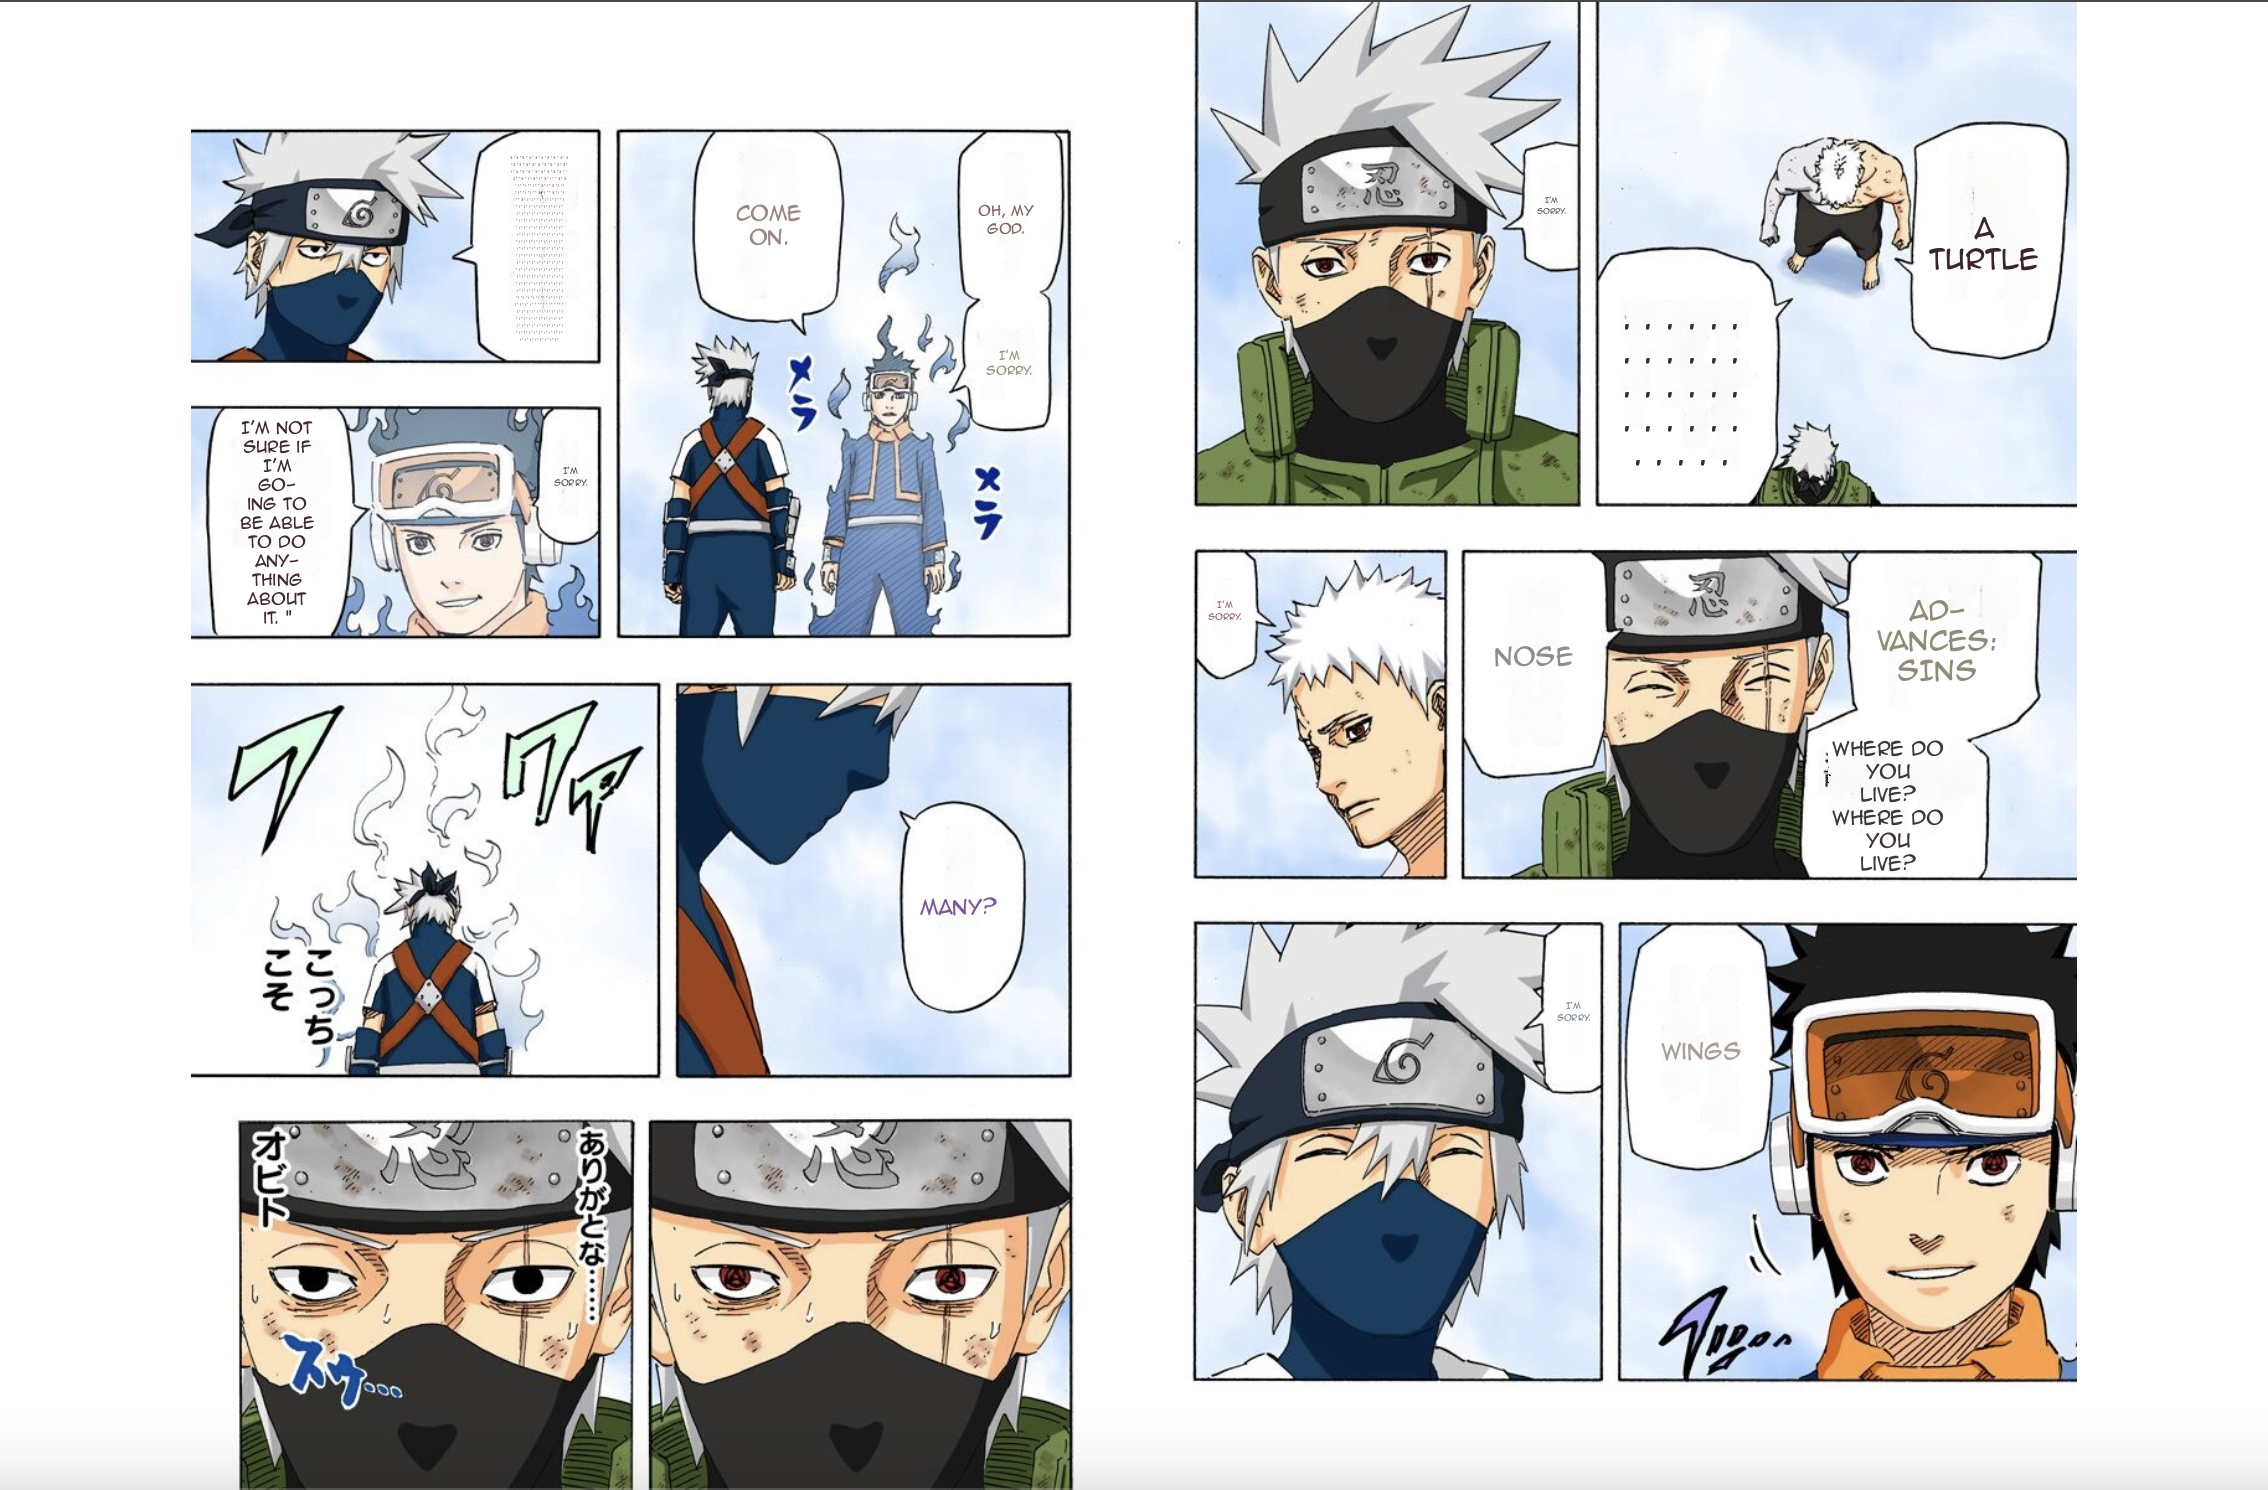

In [110]:
show_image_from_array(list(data.values())[0][0])

In [116]:
data

{'/Users/arunbhyashaswi/Drive/Code/Manga/LiveTranslatorScreen/Sample/Naruto_jp_converted.png': [array([[[ 70,  71,  69],
          [ 70,  71,  69],
          [ 70,  71,  69],
          ...,
          [ 70,  71,  69],
          [ 70,  71,  69],
          [ 70,  71,  69]],
  
         [[ 70,  71,  69],
          [ 70,  71,  69],
          [ 70,  71,  69],
          ...,
          [ 70,  71,  69],
          [ 70,  71,  69],
          [ 70,  71,  69]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         ...,
  
         [[232, 232, 232],
          [232, 232, 232],
          [232, 232, 232],
          ...,
          [232, 232, 232],
          [232, 232, 232],
          [232, 232, 232]],
  
         [[232, 232, 232],
          [232, 232, 232],
          [229, 229, 229],
          ...,
          [232, 232, 232],
          [232, 232, 232],
          [231,

In [126]:
files = ["/Users/arunbhyashaswi/Drive/Code/Manga/LiveTranslatorScreen/Sample/chacha_hi.jpg"]  # List of input image paths

# Specify models by index
translator_index = 1  # Index of the translator model
ocr_index = 2         # Index of the OCR model
drawer_index = 0     # Index of the drawer model

# JSON configuration arguments
translator_args = '{"model_url":  ""Helsinki-NLP/opus-mt-hi-en""}'  # Translator-specific arguments
ocr_args = '{"lang": "hi"}'             
drawer_args = ""
# Call the function
results = do_convert(
    files=files,
    translator=translator_index,
    translator_args=translator_args,
    ocr=ocr_index,
    ocr_args=ocr_args,
    drawer=drawer_index,
    drawer_args=drawer_args,
)

Using model Helsinki-NLP/opus-mt-hi-en


Using CPU. Note: This module is much faster with a GPU.


Pipeline created using cpu
Yolov8 Models => 0.7617089748382568 seconds
Inpainting => 0.8744409084320068 seconds
Using black since color detect model is 'None'
Color Detection => 9.059906005859375e-06 seconds
Total Process => 1.6405909061431885 seconds
/Users/arunbhyashaswi/Drive/Code/Manga/LiveTranslatorScreen/Sample/chacha_hi.jpg
Converted Batch 1/1


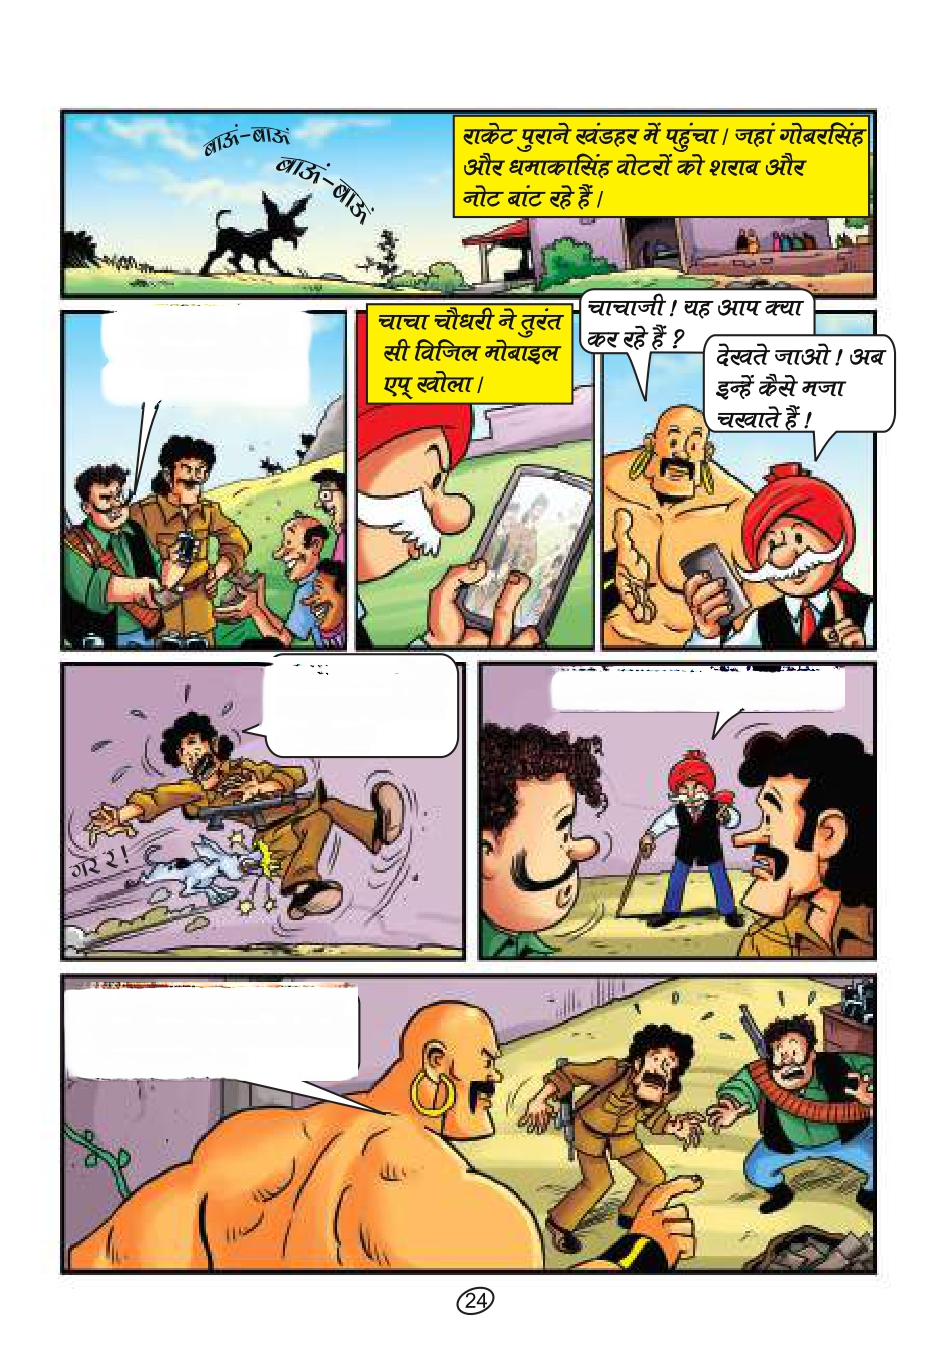

In [127]:
show_image_from_array(list(results.values())[0][0])

In [96]:
TesseractOcr.tessaract_path

'/opt/homebrew/bin/tesseract'

In [97]:
# pytesseract.pytesseract.tesseract_cmd = 
languages = pytesseract.get_languages()

In [98]:
languages

['afr',
 'amh',
 'ara',
 'asm',
 'aze',
 'aze_cyrl',
 'bel',
 'ben',
 'bod',
 'bos',
 'bre',
 'bul',
 'cat',
 'ceb',
 'ces',
 'chi_sim',
 'chi_sim_vert',
 'chi_tra',
 'chi_tra_vert',
 'chr',
 'cos',
 'cym',
 'dan',
 'deu',
 'div',
 'dzo',
 'ell',
 'eng',
 'enm',
 'epo',
 'equ',
 'est',
 'eus',
 'fao',
 'fas',
 'fil',
 'fin',
 'fra',
 'frk',
 'frm',
 'fry',
 'gla',
 'gle',
 'glg',
 'grc',
 'guj',
 'hat',
 'heb',
 'hin',
 'hrv',
 'hun',
 'hye',
 'iku',
 'ind',
 'isl',
 'ita',
 'ita_old',
 'jav',
 'jpn',
 'jpn_vert',
 'kan',
 'kat',
 'kat_old',
 'kaz',
 'khm',
 'kir',
 'kmr',
 'kor',
 'kor_vert',
 'lao',
 'lat',
 'lav',
 'lit',
 'ltz',
 'mal',
 'mar',
 'mkd',
 'mlt',
 'mon',
 'mri',
 'msa',
 'mya',
 'nep',
 'nld',
 'nor',
 'oci',
 'ori',
 'osd',
 'pan',
 'pol',
 'por',
 'pus',
 'que',
 'ron',
 'rus',
 'san',
 'sin',
 'slk',
 'slv',
 'snd',
 'snum',
 'spa',
 'spa_old',
 'sqi',
 'srp',
 'srp_latn',
 'sun',
 'swa',
 'swe',
 'syr',
 'tam',
 'tat',
 'tel',
 'tgk',
 'tha',
 'tir',
 'ton',
 'tur

In [100]:
batch = [np.array(Image.open("/Users/arunbhyashaswi/Drive/Code/Manga/LiveTranslatorScreen/Sample/chacha_hi.jpg"))]#, np.array(Image.open("example2.png"))]

tesseract_ocr = TesseractOcr(language="hin")
results = tesseract_ocr(batch)

for result in results:
    print(f"Detected text: {result.text}, Language: {result.language}")

Detected text: के को खंडहर में पहुंचा । जहां गोबरसिंह |

च्ि चौधरी ने तुरंत [|
॥ सी विजिल मोबाइल

हाई बे तुम दोनों हो / आन:
और शराब के लालच से बोटरों
बरगला रहे हो ।

, Language: hin


In [101]:
results

In [103]:
easy_ocr = EasyOcr(lang="hi")  # Replace "ja" with the desired language code
results = easy_ocr.do_ocr(batch)
for result in results:
    print(f"Text: {result.text}, Language: {result.language}")

Using CPU. Note: This module is much faster with a GPU.


Progress: |--------------------------------------------------| 1.4% Complete

Progress: |█-------------------------------------------------| 2.1% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteText: बाऊं - बाऊं बाऊं ब राकेट पुराने  खंडहर में पहुंचा | जहां गोबरसिंह और धमाकासिंह वोटरों को शराब और नोट बांट रहे हैं | चाचाजी ! यह आप क्या चाचा चौधरी ने तुरंत कर रहे हैं ? सी विजिल मोबाइल देखते जाओ अब एप् खोला | इन्हें कैसे मजा चखाते हैं ये रुपए लो , हमारे उम्मीदवार को ही वोट डालना अरे चाचा चौधरी का कुत्ता यहां कैसे आ ग्या ? बांटे हुए नोट ले आएं हैं वे तुम दोनों हो ! जो रुपए और शराब के लालच से वोटरों को बरगला रहे हो|, Language: hi


In [124]:
from transformers import MarianMTModel, MarianTokenizer

# Load the tokenizer and model
model_name = "Helsinki-NLP/opus-mt-hi-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Example text to translate
text = "बाऊं - बाऊं बाऊं ब राकेट पुराने  खंडहर में पहुंचा | जहां गोबरसिंह और धमाकासिंह वोटरों को शराब और नोट बांट रहे हैं | चाचाजी ! यह आप क्या चाचा चौधरी ने तुरंत कर रहे हैं ? सी विजिल मोबाइल देखते जाओ अब एप् खोला | इन्हें कैसे मजा चखाते हैं ये रुपए लो , हमारे उम्मीदवार को ही वोट डालना अरे चाचा चौधरी का कुत्ता यहां कैसे आ ग्या ? बांटे हुए नोट ले आएं हैं वे तुम दोनों हो ! जो रुपए और शराब के लालच से वोटरों को बरगला रहे हो|"

# Tokenize the text
inputs = tokenizer(text, return_tensors="pt", padding=True)

# Generate translation
translated_tokens = model.generate(**inputs)
translated_text = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]

print(f"Translated text: {translated_text}")


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/304M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Translated text: Go ahead and go to old ruins where the cats and the lions are dividing wine and noteing wine and drinks to the Indians! What's this Uncle Lawi doing to you right away?
